# bb

In [1]:
pip install levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import numpy as np

from Levenshtein import distance as lev

from tqdm.notebook import tqdm, trange

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.utils.data import Dataset

from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math

import pygame
import sys

from torch.nn.utils.rnn import pad_sequence

from timeit import default_timer as timer

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [3]:
df_Nikolskaya = pd.read_csv("pathes.csv", sep=';')

In [4]:
df_Nikolskaya

animal id  experience  test  \
0        fish  2           4     1   
1        fish  2           4     2   
2        fish  2           4     3   
3        fish  2           5     1   
4        fish  2           5     2   
...       ... ..         ...   ...   
29213  monkey  3          15    11   
29214  monkey  3          15    12   
29215  monkey  3          15    13   
29216  monkey  3          15    14   
29217  monkey  3          15    15   

                                                    path  
0                                 ПОООООИЛКА+КЛЛКШХЦЩЗСТ  
1                                        ПОООИИООИКА+ДСР  
2      ПОМЛЛКЩЦХХЦЩЗСССЖЛМООИИИИИИИИООИЛЛКШЧЦЩКЛЖСССС...  
3      ПОММММООМКГ+ЩЦЦЦХША+ШХЦЦХХЦЩГККЗСССТСЗГ+ЩЦХША+...  
4      НОМКГ-ЩЦХШКЛЛКА-ЧЦЩГ-ССЗЩЦХШККЛБЛИИИИИООМККЛЖТ...  
...                                                  ...  
29213                                    ОМЯГЯМИКАКИМЭЖТ  
29214                                         ОИКАКИМЭЖТ  
29215                                         ОИКАКИМЭЖТ  
29216                                         ОИКАКИМЭЖТ  
29217                                       ОИККИМЯГЯЭЖТ  

[29218 rows x 5 columns]

In [5]:
df_Nikolskaya['path'] = df_Nikolskaya['path'].str.replace('+', '', regex=True)
df_Nikolskaya['path'] = df_Nikolskaya['path'].str.replace('-', '', regex=True)
df_Nikolskaya

animal id  experience  test  \
0        fish  2           4     1   
1        fish  2           4     2   
2        fish  2           4     3   
3        fish  2           5     1   
4        fish  2           5     2   
...       ... ..         ...   ...   
29213  monkey  3          15    11   
29214  monkey  3          15    12   
29215  monkey  3          15    13   
29216  monkey  3          15    14   
29217  monkey  3          15    15   

                                                    path  
0                                  ПОООООИЛКАКЛЛКШХЦЩЗСТ  
1                                         ПОООИИООИКАДСР  
2      ПОМЛЛКЩЦХХЦЩЗСССЖЛМООИИИИИИИИООИЛЛКШЧЦЩКЛЖСССС...  
3      ПОММММООМКГЩЦЦЦХШАШХЦЦХХЦЩГККЗСССТСЗГЩЦХШАККХЦ...  
4      НОМКГЩЦХШКЛЛКАЧЦЩГССЗЩЦХШККЛБЛИИИИИООМККЛЖТЖЛИ...  
...                                                  ...  
29213                                    ОМЯГЯМИКАКИМЭЖТ  
29214                                         ОИКАКИМЭЖТ  
29215                                         ОИКАКИМЭЖТ  
29216                                         ОИКАКИМЭЖТ  
29217                                       ОИККИМЯГЯЭЖТ  

[29218 rows x 5 columns]

In [6]:
df_Nikolskaya['input'] = df_Nikolskaya.apply(lambda x: str(x['animal']) + ' ' + str(x['experience']) + ' ' + str(x['test']), axis=1)
df_Nikolskaya['path'] = df_Nikolskaya.apply(lambda x: ' '.join(list(str(x['path']))), axis=1)
df_Nikolskaya['path'] = df_Nikolskaya.apply(lambda x: x['path'] if (x['path'][0] != 'П' and x['path'][0] != 'Н') else x['path'][1:], axis=1)
df_Nikolskaya

animal id  experience  test  \
0        fish  2           4     1   
1        fish  2           4     2   
2        fish  2           4     3   
3        fish  2           5     1   
4        fish  2           5     2   
...       ... ..         ...   ...   
29213  monkey  3          15    11   
29214  monkey  3          15    12   
29215  monkey  3          15    13   
29216  monkey  3          15    14   
29217  monkey  3          15    15   

                                                    path         input  
0                О О О О О И Л К А К Л Л К Ш Х Ц Щ З С Т      fish 4 1  
1                              О О О И И О О И К А Д С Р      fish 4 2  
2       О М Л Л К Щ Ц Х Х Ц Щ З С С С Ж Л М О О И И И...      fish 4 3  
3       О М М М М О О М К Г Щ Ц Ц Ц Х Ш А Ш Х Ц Ц Х Х...      fish 5 1  
4       О М К Г Щ Ц Х Ш К Л Л К А Ч Ц Щ Г С С З Щ Ц Х...      fish 5 2  
...                                                  ...           ...  
29213                      О М Я Г Я М И К А К И М Э Ж Т  monkey 15 11  
29214                                О И К А К И М Э Ж Т  monkey 15 12  
29215                                О И К А К И М Э Ж Т  monkey 15 13  
29216                                О И К А К И М Э Ж Т  monkey 15 14  
29217                            О И К К И М Я Г Я Э Ж Т  monkey 15 15  

[29218 rows x 6 columns]

In [7]:
df_Nikolskaya['animal'].unique()

array(['fish', 'mouse', 'person', 'monkey'], dtype=object)

In [8]:
tmp_df = df_Nikolskaya[['input', 'path']]
tmp_df

input                                               path
0          fish 4 1            О О О О О И Л К А К Л Л К Ш Х Ц Щ З С Т
1          fish 4 2                          О О О И И О О И К А Д С Р
2          fish 4 3   О М Л Л К Щ Ц Х Х Ц Щ З С С С Ж Л М О О И И И...
3          fish 5 1   О М М М М О О М К Г Щ Ц Ц Ц Х Ш А Ш Х Ц Ц Х Х...
4          fish 5 2   О М К Г Щ Ц Х Ш К Л Л К А Ч Ц Щ Г С С З Щ Ц Х...
...             ...                                                ...
29213  monkey 15 11                      О М Я Г Я М И К А К И М Э Ж Т
29214  monkey 15 12                                О И К А К И М Э Ж Т
29215  monkey 15 13                                О И К А К И М Э Ж Т
29216  monkey 15 14                                О И К А К И М Э Ж Т
29217  monkey 15 15                            О И К К И М Я Г Я Э Ж Т

[29218 rows x 2 columns]

In [9]:
tmp_df_mouse = df_Nikolskaya[df_Nikolskaya['animal'] == 'mouse'][['input', 'path']]

In [10]:
tmp_df_fish = df_Nikolskaya[df_Nikolskaya['animal'] == 'fish'][['input', 'path']]

In [11]:
tmp_df_monkey = df_Nikolskaya[df_Nikolskaya['animal'] == 'monkey'][['input', 'path']]

In [12]:
tmp_df_person = df_Nikolskaya[df_Nikolskaya['animal'] == 'person'][['input', 'path']]

In [13]:
df_train, df_valid = train_test_split(tmp_df_mouse, test_size=0.2, random_state=42)
df_train.to_csv('mouse_train_inp', sep='\t', encoding='utf-8', columns=['input'], index=False, header=False)
df_train.to_csv('mouse_train_trg', sep='\t', encoding='utf-8', columns=['path'], index=False, header=False)
df_valid.to_csv('mouse_valid_inp', sep='\t', encoding='utf-8', columns=['input'], index=False, header=False)
df_valid.to_csv('mouse_valid_trg', sep='\t', encoding='utf-8', columns=['path'], index=False, header=False)

In [14]:
df_train, df_valid = train_test_split(tmp_df_fish, test_size=0.2, random_state=42)
df_train.to_csv('fish_train_inp', sep='\t', encoding='utf-8', columns=['input'], index=False, header=False)
df_train.to_csv('fish_train_trg', sep='\t', encoding='utf-8', columns=['path'], index=False, header=False)
df_valid.to_csv('fish_valid_inp', sep='\t', encoding='utf-8', columns=['input'], index=False, header=False)
df_valid.to_csv('fish_valid_trg', sep='\t', encoding='utf-8', columns=['path'], index=False, header=False)

In [15]:
df_train, df_valid = train_test_split(tmp_df_monkey, test_size=0.2, random_state=42)
df_train.to_csv('monkey_train_inp', sep='\t', encoding='utf-8', columns=['input'], index=False, header=False)
df_train.to_csv('monkey_train_trg', sep='\t', encoding='utf-8', columns=['path'], index=False, header=False)
df_valid.to_csv('monkey_valid_inp', sep='\t', encoding='utf-8', columns=['input'], index=False, header=False)
df_valid.to_csv('monkey_valid_trg', sep='\t', encoding='utf-8', columns=['path'], index=False, header=False)

In [16]:
df_train, df_valid = train_test_split(tmp_df_person, test_size=0.2, random_state=42)
df_train.to_csv('person_train_inp', sep='\t', encoding='utf-8', columns=['input'], index=False, header=False)
df_train.to_csv('person_train_trg', sep='\t', encoding='utf-8', columns=['path'], index=False, header=False)
df_valid.to_csv('person_valid_inp', sep='\t', encoding='utf-8', columns=['input'], index=False, header=False)
df_valid.to_csv('person_valid_trg', sep='\t', encoding='utf-8', columns=['path'], index=False, header=False)

In [17]:
df_Berezhnoy = pd.read_csv("berezhnoy_pathes.csv", sep=';')
df_Berezhnoy['path'] = df_Berezhnoy['path'].str.replace('+', '', regex=True)
df_Berezhnoy['path'] = df_Berezhnoy['path'].str.replace('-', '', regex=True)
df_Berezhnoy

animal  id  experience  test  \
0   mouse   1           1     1   
1   mouse   1           1     2   
2   mouse   1           1     3   
3   mouse   1           1     4   
4   mouse   1           1     5   
..    ...  ..         ...   ...   
75  mouse   1           7     6   
76  mouse   1           7     7   
77  mouse   1           7     8   
78  mouse   1           7     9   
79  mouse   1           7    10   

                                                 path  
0   KAEIMNOPLHDCBAAEIMMNOPPLHHGGFEEAABBCDHGFFJJNMM...  
1                                        KGFEIEFBBCGK  
2                                    KOONMMIEAABCGGKK  
3                                               KOPLK  
4                                             KJINMJK  
..                                                ...  
75                                  KJJNNMMIIEAABFGKK  
76                                       KJJFFGHDDHGK  
77                                KKOPPONNJJKKKOOPLLK  
78                                        KJIIMMNOOOK  
79                                   KJJFFBFEIMNNJJFF  

[80 rows x 5 columns]

In [18]:
df_Chelnok = pd.read_csv("chelnok_pathes.csv", sep=';')
df_Chelnok['path'] = df_Chelnok['path'].str.replace('+', '', regex=True)
df_Chelnok['path'] = df_Chelnok['path'].str.replace('-', '', regex=True)
df_Chelnok

animal  id  experience  test  \
0   mouse   1           1     1   
1   mouse   1           1     2   
2   mouse   1           1     3   
3   mouse   1           1     4   
4   mouse   1           2     1   
..    ...  ..         ...   ...   
91  mouse   2          18     1   
92  mouse   2          18     2   
93  mouse   2          18     3   
94  mouse   2          18     4   
95  mouse   2          18     5   

                                                 path  
0                           МЭВЧОФХДСШРЕЮЧЖТЩУЗЦХЦЯЙН  
1          УЗЦХДСШРЕЛКАДХЦГЗУНЩТЖЧЮЕРШПЁИФХДСЁКАХЦЗУН  
2                           ЙЙМИЛЮЧЖТЩЙМИЁПШПСДХЦГЗУН  
3   ЩТЖЧОФХДХЦЗУНЙУНУНЙЭВЖЩНЙМИЁППШРЕЛЁПППШЕЮЧВЖЩУ...  
4                          ИЛБЮЧЭЯГЦФИЁПШЕЛЁПШРЕЮЧЖЩН  
..                                                ...  
91                                           УЗГЦХДСП  
92                                     СПЁИМЙНЩЖЧЮЕШП  
93                                    ЁИМЙНЙНЩЖЧЮЕЕШП  
94                                      ЁИМЙНЙЙНЙМИЁП  
95                                              СДКЁП  

[96 rows x 5 columns]

# Transformers

In [36]:
from functions_ import *
from path_ import *
from info_ import *

In [20]:
SRC_ = 'animal'
TGT_ = 'path'

token_transform = {}
vocab_transform = {}
text_transform = {}

EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

token_transform[SRC_] = get_tokenizer(None, language='en')
token_transform[TGT_] = get_tokenizer(None, language='en')
torch.manual_seed(0)

## Fish

In [21]:
def yield_tokens(data_iter, data_type):
    data_named_index = {SRC_: 0, TGT_: 1}
    for data_sample in data_iter:
        yield token_transform[data_type](data_sample[data_named_index[data_type]])

for el in [SRC_, TGT_]:
    train_iter = MyDataset(src_file='fish_train_inp', tgt_file='fish_train_trg')
    vocab_transform[el] = build_vocab_from_iterator(yield_tokens(train_iter, el),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)
    
for el in [SRC_, TGT_]:
  vocab_transform[el].set_default_index(UNK_IDX)

In [22]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_])

transformer = Input2PathTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
for el in [SRC_, TGT_]:
    text_transform[el] = sequential_transforms(token_transform[el],
                                               vocab_transform[el],
                                               tensor_transform)

In [23]:
def collate_fn(batch):
    src_batch, tgt_batch = zip(*[(text_transform[SRC_](src_sample.rstrip("\n")),
                                 text_transform[TGT_](tgt_sample.rstrip("\n")))
                                for src_sample, tgt_sample in batch])
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch


def process_epoch(model, optimizer, dataloader, tqdm_desc): # ? optimizer
    model.train() if model.training else model.eval()
    total_loss = 0
    total_batches = len(dataloader)

    for src, tgt in tqdm(dataloader, desc=tqdm_desc):
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        total_loss += loss.item()

        if model.training and optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    average_loss = total_loss / total_batches
    return average_loss

def train_epoch(model, optimizer, tqdm_desc, src_file, tgt_file, text_transform):
    train_dataset = MyDataset(src_file=src_file, tgt_file=tgt_file)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    return process_epoch(model, optimizer, train_dataloader, tqdm_desc)

def valid_epoch(model, src_file, tgt_file, text_transform):
    val_dataset = MyDataset(src_file=src_file, tgt_file=tgt_file)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    return process_epoch(model, None, val_dataloader, "Validation")

Training 1/15:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1, Train loss: 3.559, Val loss: 3.095, Epoch time = 2.092s


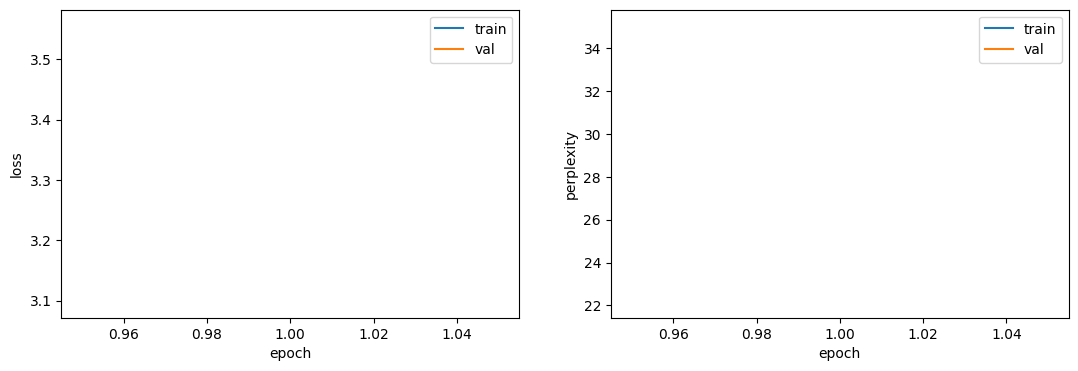

Training 2/15:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 2, Train loss: 2.906, Val loss: 2.825, Epoch time = 1.066s


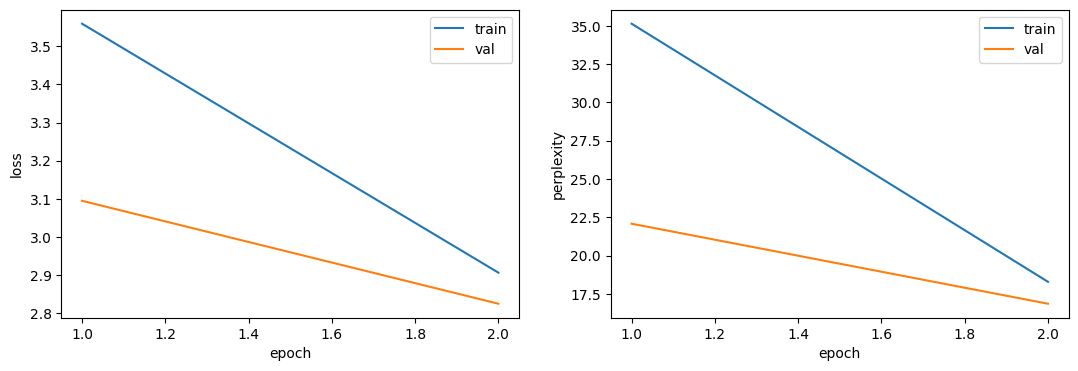

Training 3/15:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 3, Train loss: 2.740, Val loss: 2.697, Epoch time = 0.822s


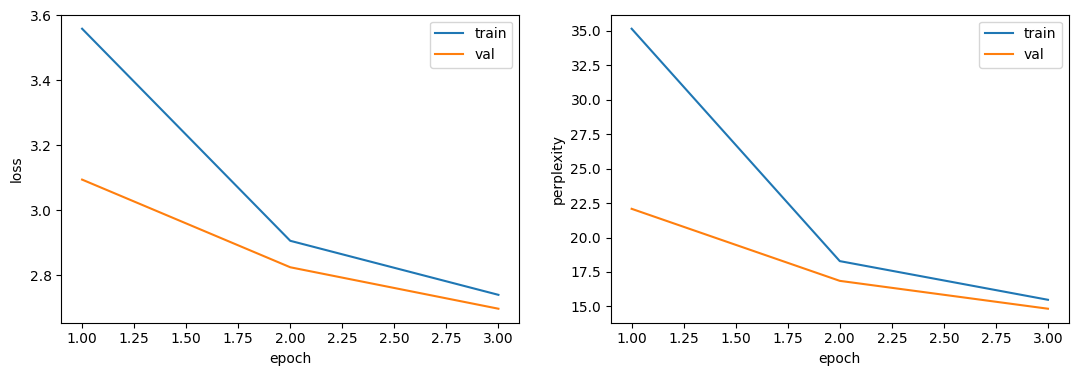

Training 4/15:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4, Train loss: 2.552, Val loss: 2.593, Epoch time = 0.934s


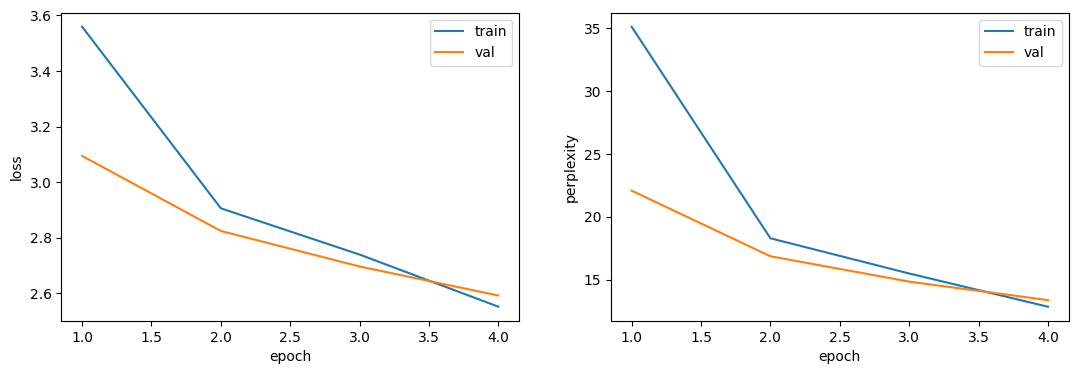

Training 5/15:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5, Train loss: 2.403, Val loss: 2.376, Epoch time = 0.781s


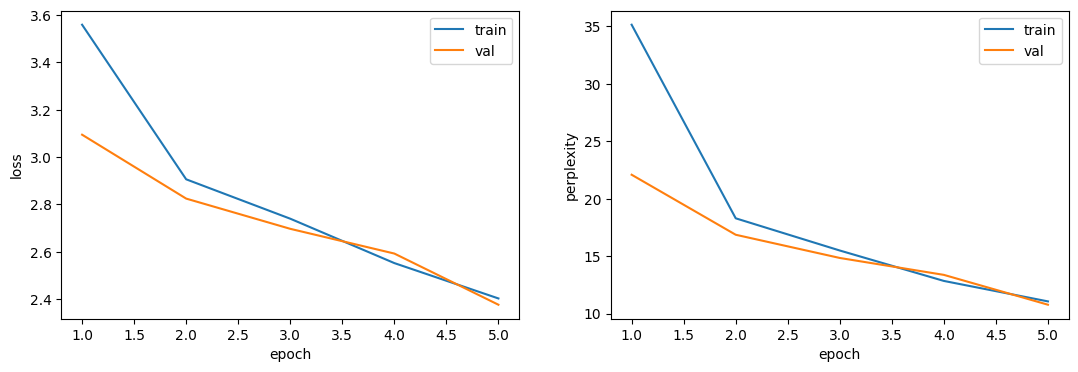

Training 6/15:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 6, Train loss: 2.225, Val loss: 2.230, Epoch time = 0.754s


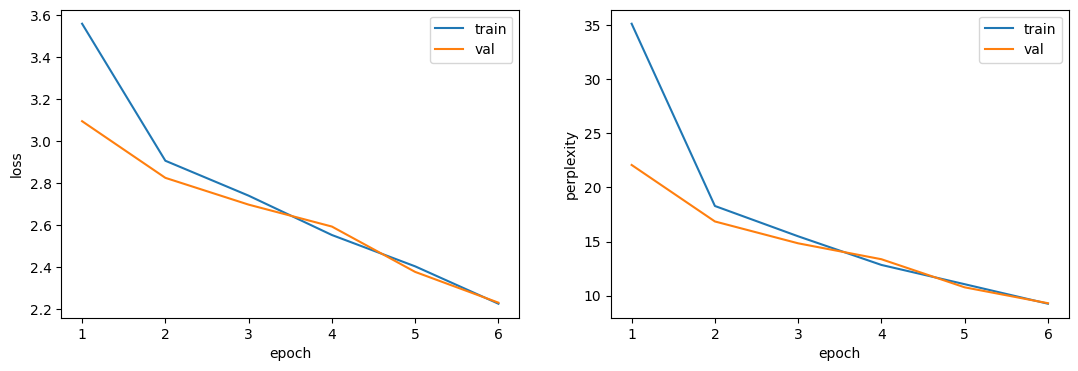

Training 7/15:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 7, Train loss: 2.070, Val loss: 2.147, Epoch time = 0.756s


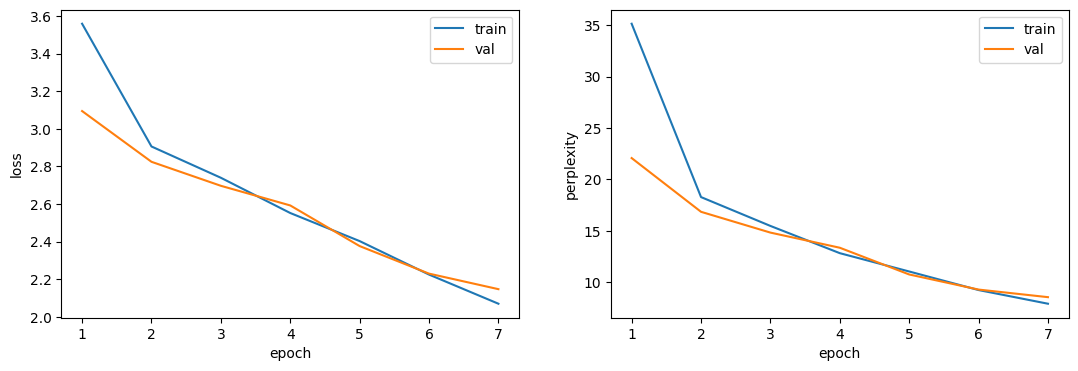

Training 8/15:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 8, Train loss: 1.982, Val loss: 2.013, Epoch time = 0.754s


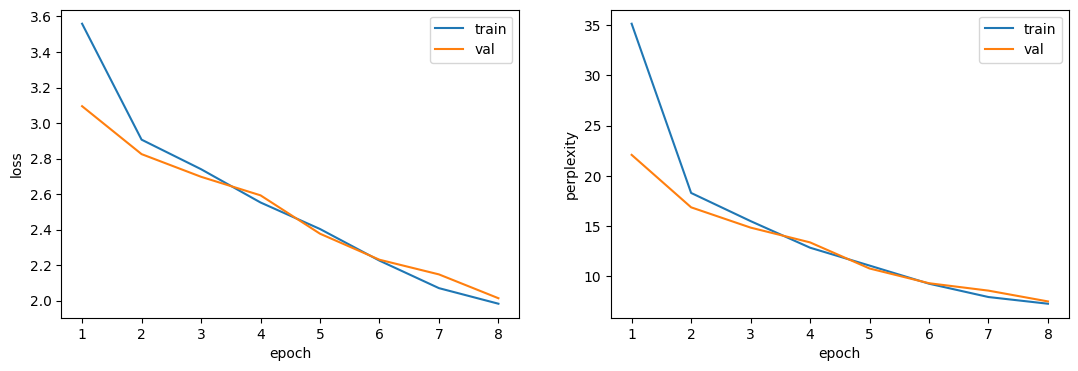

Training 9/15:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 9, Train loss: 1.868, Val loss: 1.927, Epoch time = 0.744s


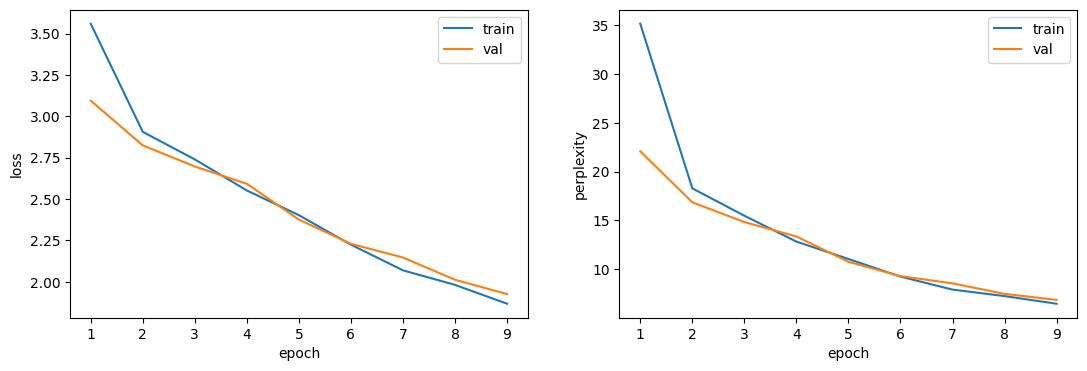

Training 10/15:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10, Train loss: 1.810, Val loss: 1.853, Epoch time = 0.752s


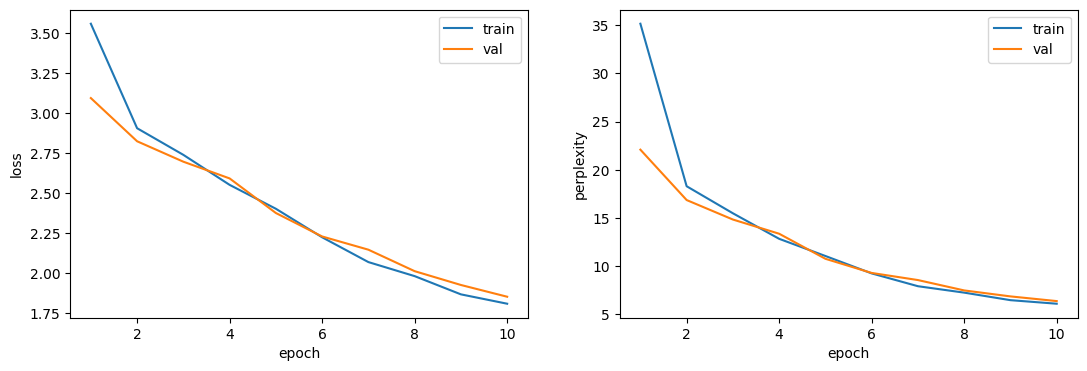

Training 11/15:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11, Train loss: 1.747, Val loss: 1.833, Epoch time = 0.791s


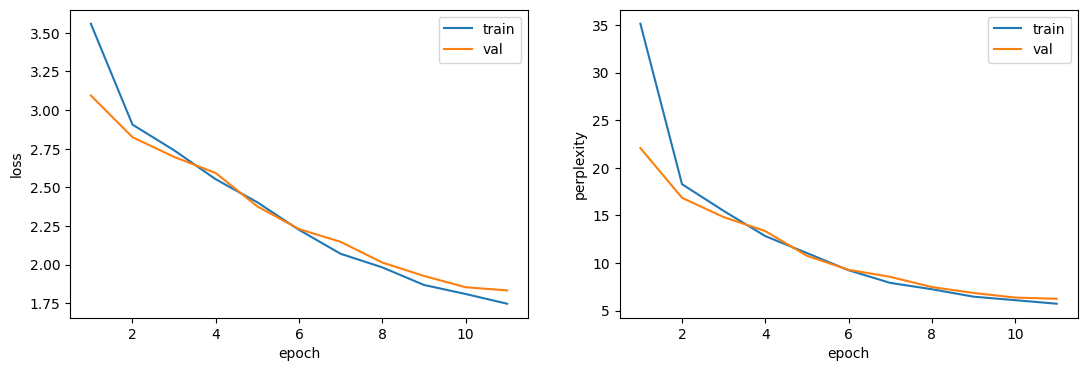

Training 12/15:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12, Train loss: 1.704, Val loss: 1.787, Epoch time = 0.777s


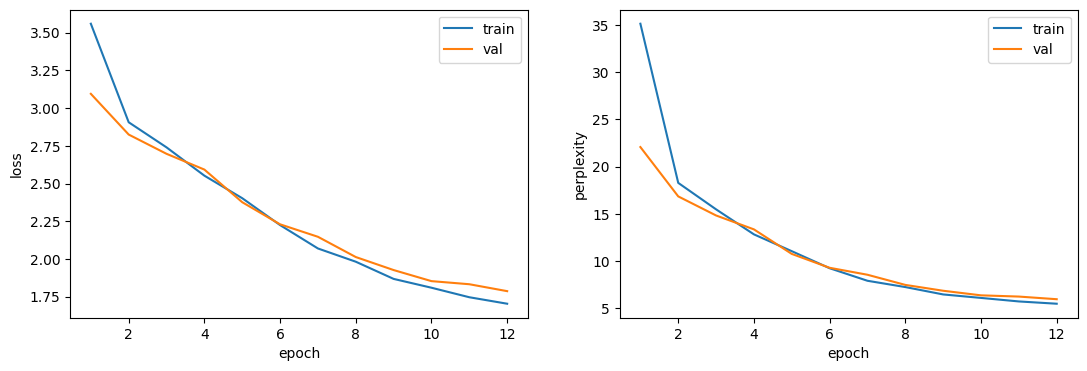

Training 13/15:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13, Train loss: 1.650, Val loss: 1.741, Epoch time = 0.747s


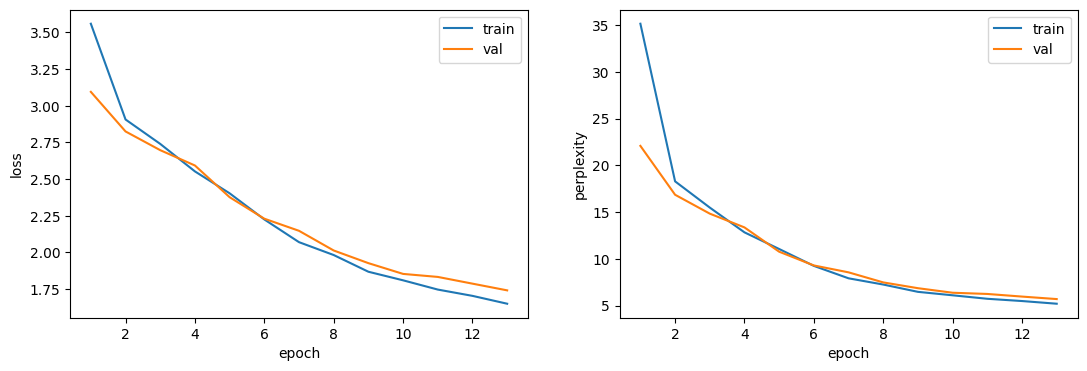

Training 14/15:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14, Train loss: 1.628, Val loss: 1.732, Epoch time = 0.755s


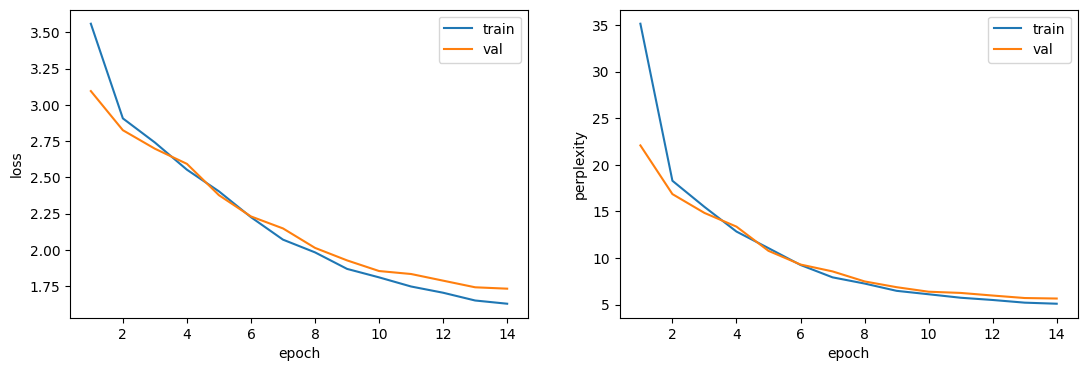

Training 15/15:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15, Train loss: 1.594, Val loss: 1.712, Epoch time = 0.764s


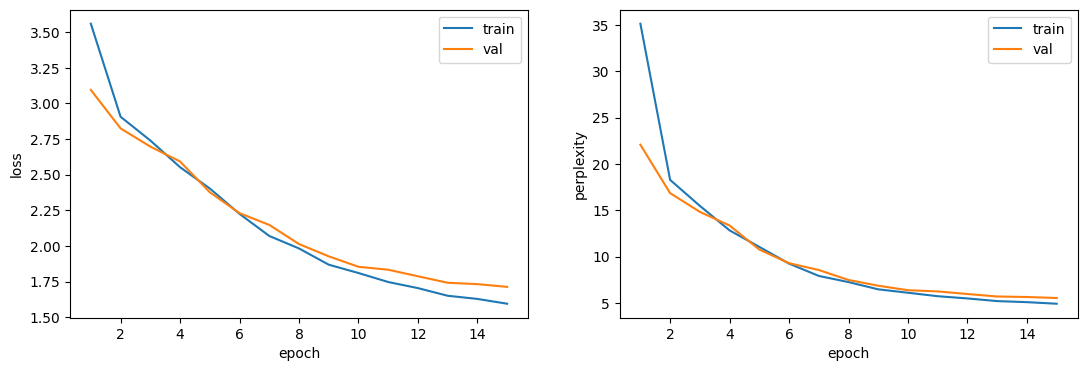

In [24]:
NUM_EPOCHS = 15
train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, f'Training {epoch}/{NUM_EPOCHS}', 'fish_train_inp', 'fish_train_trg', text_transform)
    end_time = timer()
    val_loss = valid_epoch(transformer, 'fish_valid_inp', 'fish_valid_trg', text_transform)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    train_losses += [train_loss]
    val_losses += [val_loss]
    plot_losses(train_losses, val_losses)

In [25]:
tmp_df_fish['generated'] = tmp_df_fish.apply(lambda x: answer(transformer, x['input'], text_transform, vocab_transform), axis=1)

In [26]:
tmp_df_fish['Lev'] = -1
tmp_df_fish['Lev'] = tmp_df_fish.apply(lambda x: lev(''.join(x['generated'].split()), ''.join(x['path'].split())), axis=1)

In [27]:
tmp_df_fish.sort_values(by='Lev')

input                                               path  \
126  fish 14 1                              О Ф Х Ш А К К А Д С Р   
294   fish 9 2                              О Ф Х Ш К К Д С С С Р   
332  fish 22 3                                  О Ф Ф М Л Л К З Т   
104   fish 6 4                        О Ф Х Ш А Ш Х Ц Щ З С Ж Ж Т   
215  fish 15 1                                    О Ф Х Ш К Л Е Р   
..         ...                                                ...   
219  fish 16 1   О Ф Х Ш К И И К Ш Х Ц Г З С С З Г Г К К Щ З С...   
281   fish 5 2   О Ф Ц Щ З С С З Щ Ц Х Х Ц Щ З С С С С С С З Щ...   
279   fish 4 3   О Ф Х Ш А Д Д К Л Л К Д С С Д Ш Х Ц Щ Г З С С...   
293   fish 9 1   О Ф Х Ш Д Д Ш Х Ц Щ З З Щ Ц Ц Щ Г Г Щ Ц Х Ш Д...   
283   fish 6 1   О Ф Ц Щ Г З С С З Щ Ц Х Х Ц Щ З С С С С С С С...   

              generated  Lev  
126   О Ф Х Ш А Д С Д С    4  
294   О Ф Х Ш А Д С С Д    4  
332   О Ф Ф Х Ш А К К К    5  
104   О Ф Х Ш А Ш Х Ц Щ    5  
215   О Ф Х Ш А Д С С С    5  
..                  ...  ...  
219   О Ф Х Ш А Ш А К К  142  
281   О Ф Ф Ф Ц Щ К Л Л  144  
279   О Ф Х Ш А Ш Х Ц Щ  148  
293   О Ф Х Ш А Д С С Д  149  
283   О Ф Ф Х Ш А К Л К  168  

[342 rows x 4 columns]

In [37]:
tmp_df_fish['generated'] = tmp_df_fish.apply(lambda x: x['generated'] + ' Р' if len(path_Nikolskaya(x['generated'][-1] + 'Р', maze_Nikolskaya)) < len(path_Nikolskaya(x['generated'][-1] + 'Т', maze_Nikolskaya)) else x['generated'] + ' Т', axis=1)

# Mouse

In [38]:
token_transform = {}
vocab_transform = {}
text_transform = {}

In [43]:
token_transform[SRC_] = get_tokenizer(None, language='en')
token_transform[TGT_] = get_tokenizer(None, language='en')

In [44]:
def yield_tokens(data_iter, data_type):
    data_named_index = {SRC_: 0, TGT_: 1}
    for data_sample in data_iter:
        yield token_transform[data_type](data_sample[data_named_index[data_type]])

for el in [SRC_, TGT_]:
    train_iter = MyDataset(src_file='mouse_train_inp', tgt_file='mouse_train_trg')
    vocab_transform[el] = build_vocab_from_iterator(yield_tokens(train_iter, el),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)
    
for el in [SRC_, TGT_]:
  vocab_transform[el].set_default_index(UNK_IDX)

In [45]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_])

transformer = Input2PathTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
for el in [SRC_, TGT_]:
    text_transform[el] = sequential_transforms(token_transform[el],
                                               vocab_transform[el],
                                               tensor_transform)

Training 1/15:   0%|          | 0/170 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 1, Train loss: 1.211, Val loss: 0.922, Epoch time = 41.224s


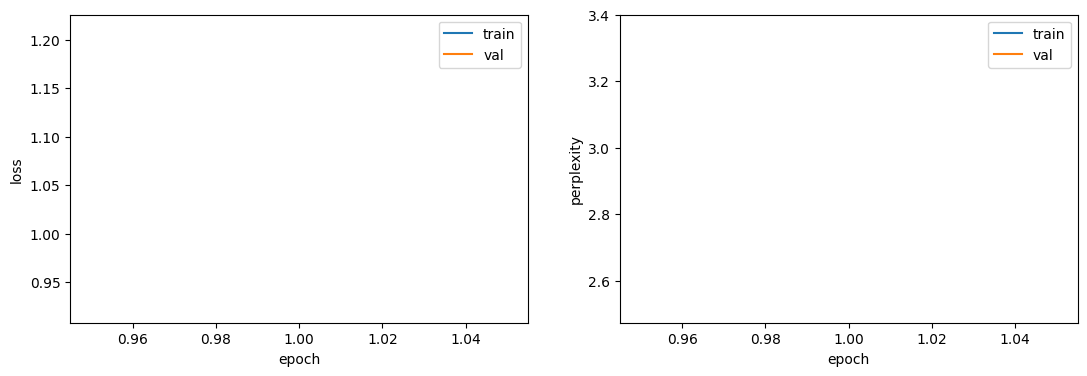

Training 2/15:   0%|          | 0/170 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 2, Train loss: 0.867, Val loss: 0.855, Epoch time = 40.170s


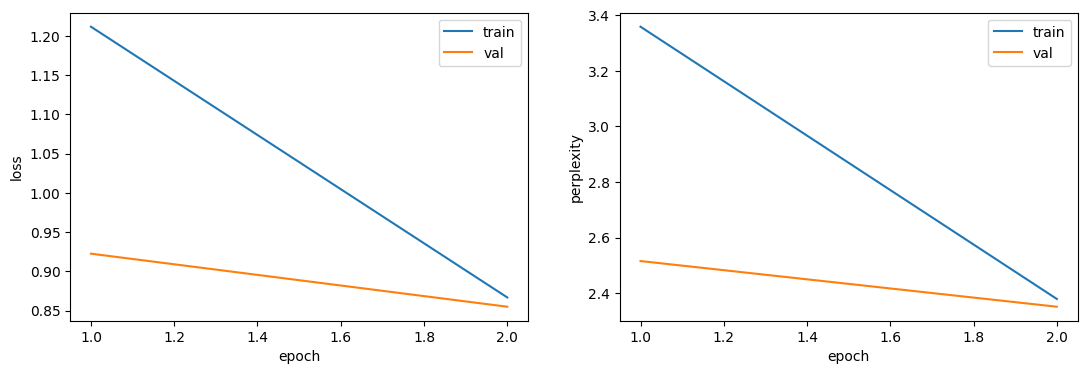

Training 3/15:   0%|          | 0/170 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 3, Train loss: 0.819, Val loss: 0.827, Epoch time = 40.378s


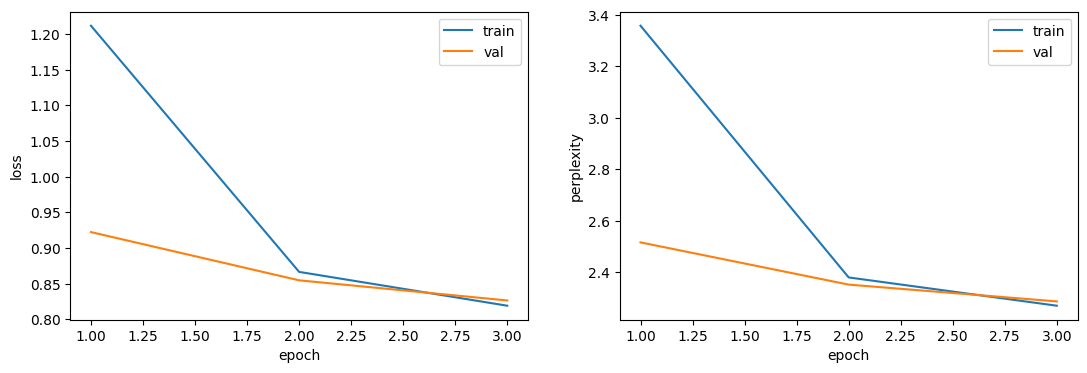

Training 4/15:   0%|          | 0/170 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.795, Val loss: 0.807, Epoch time = 40.046s


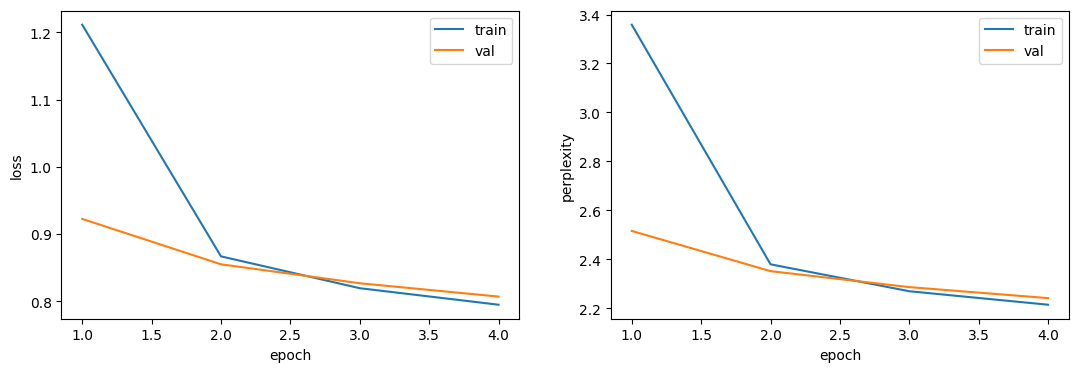

Training 5/15:   0%|          | 0/170 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 5, Train loss: 0.778, Val loss: 0.792, Epoch time = 42.028s


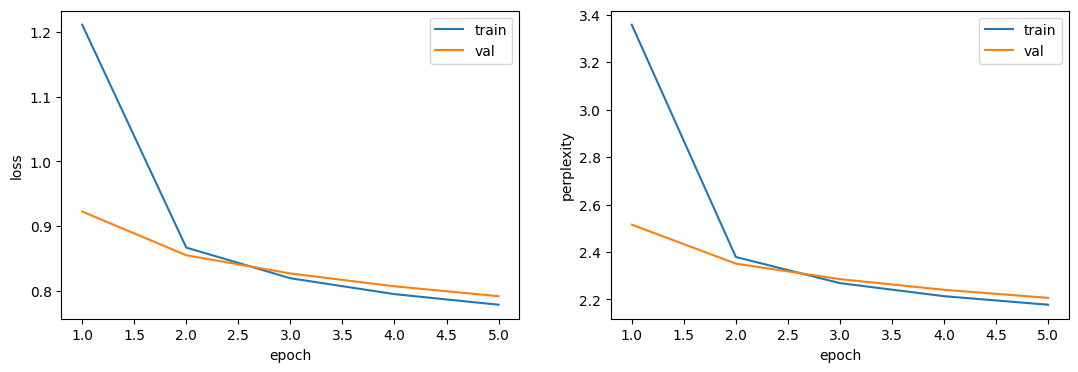

Training 6/15:   0%|          | 0/170 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 6, Train loss: 0.767, Val loss: 0.783, Epoch time = 40.775s


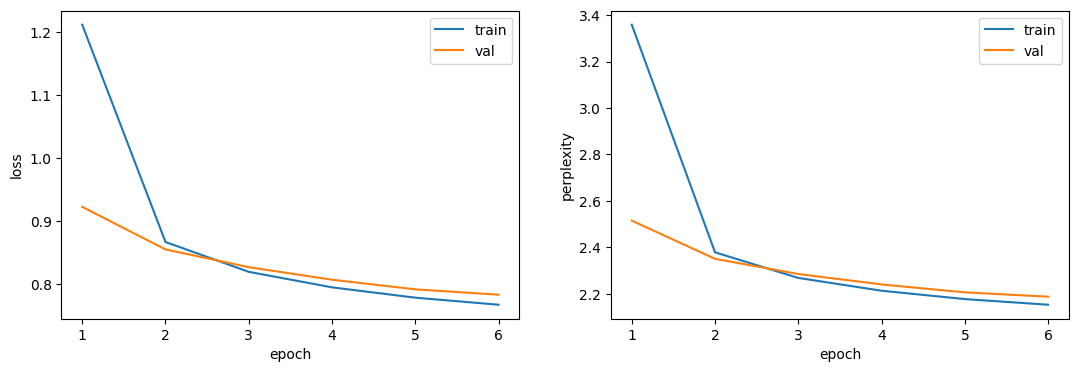

Training 7/15:   0%|          | 0/170 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 7, Train loss: 0.759, Val loss: 0.775, Epoch time = 41.025s


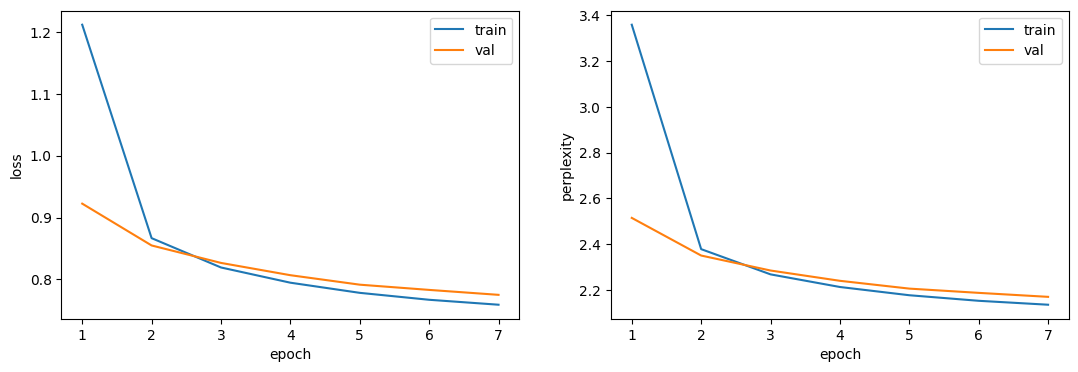

Training 8/15:   0%|          | 0/170 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 8, Train loss: 0.752, Val loss: 0.768, Epoch time = 40.385s


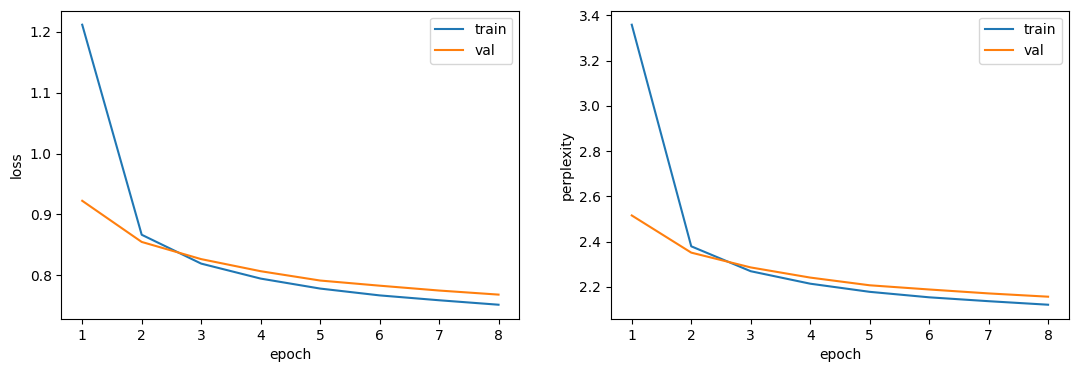

Training 9/15:   0%|          | 0/170 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 9, Train loss: 0.746, Val loss: 0.763, Epoch time = 40.565s


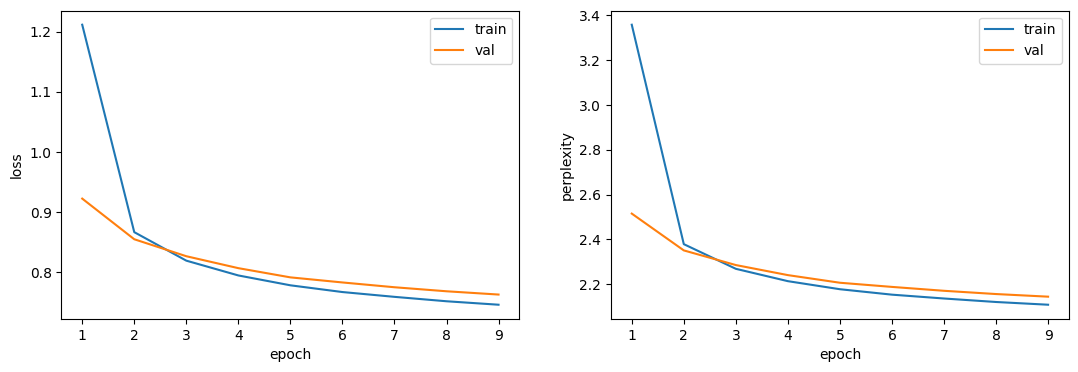

Training 10/15:   0%|          | 0/170 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10, Train loss: 0.741, Val loss: 0.758, Epoch time = 40.654s


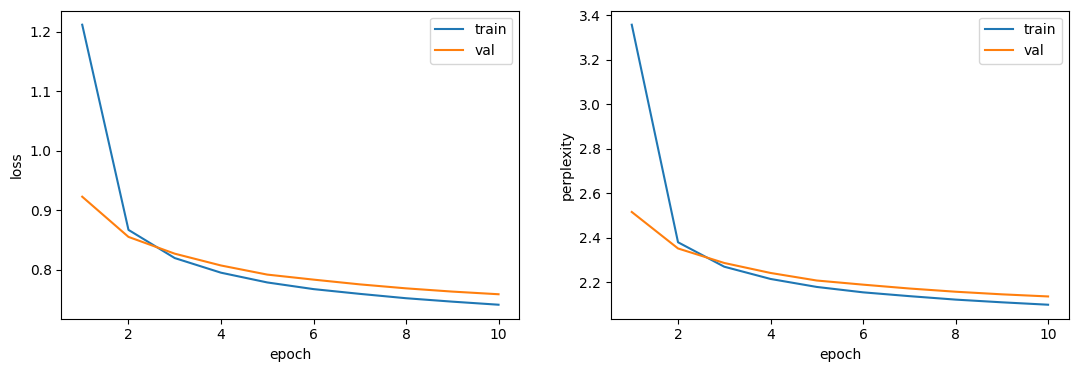

Training 11/15:   0%|          | 0/170 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11, Train loss: 0.737, Val loss: 0.755, Epoch time = 40.473s


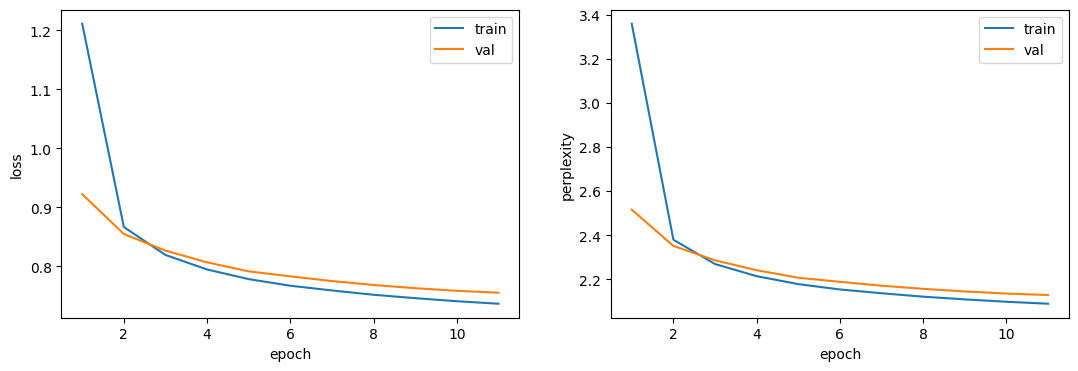

Training 12/15:   0%|          | 0/170 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12, Train loss: 0.733, Val loss: 0.753, Epoch time = 40.609s


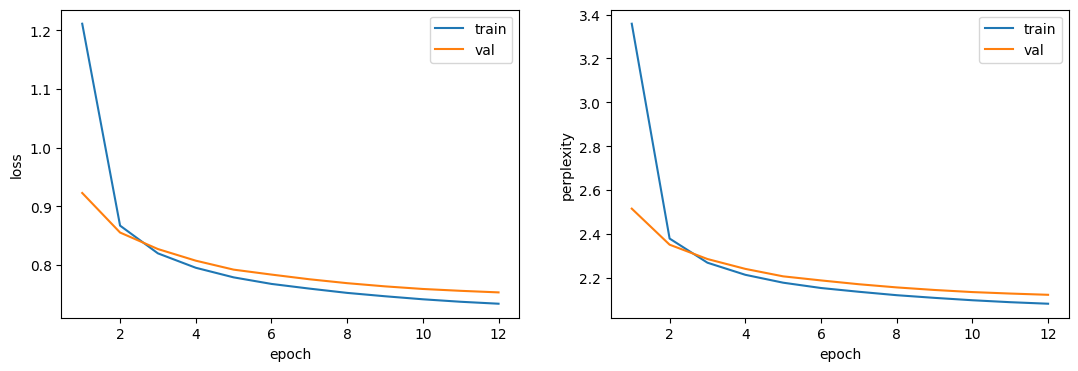

Training 13/15:   0%|          | 0/170 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13, Train loss: 0.730, Val loss: 0.753, Epoch time = 40.439s


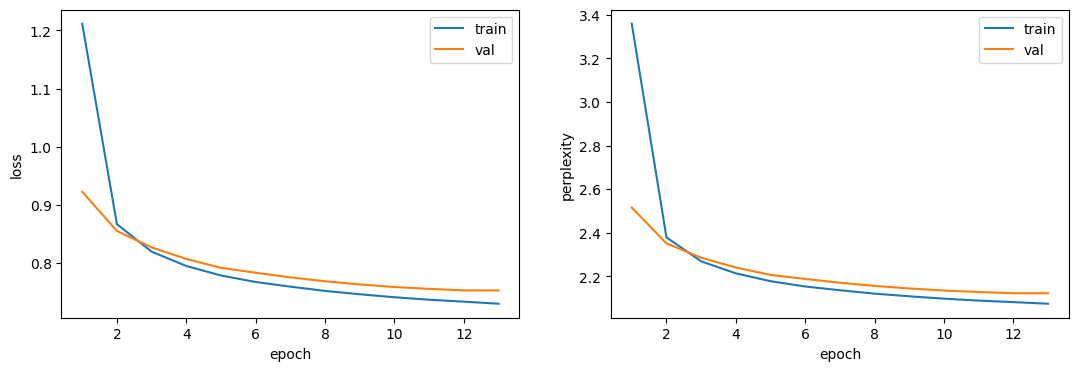

Training 14/15:   0%|          | 0/170 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14, Train loss: 0.727, Val loss: 0.749, Epoch time = 40.401s


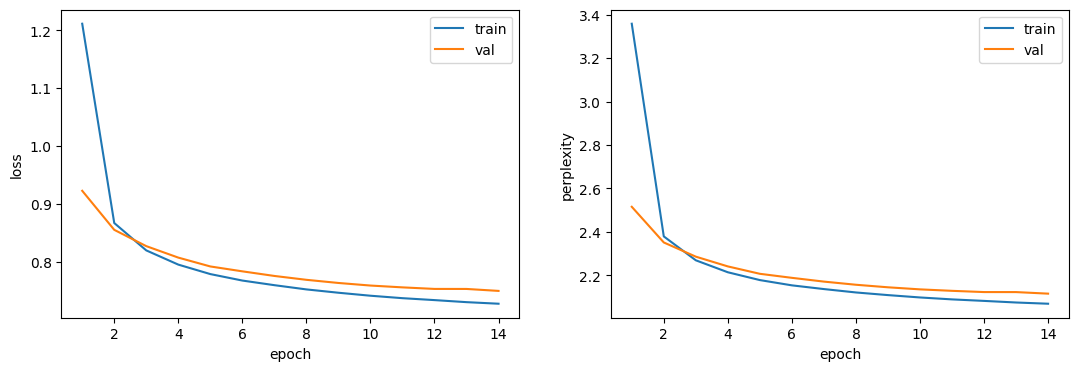

Training 15/15:   0%|          | 0/170 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15, Train loss: 0.724, Val loss: 0.748, Epoch time = 40.594s


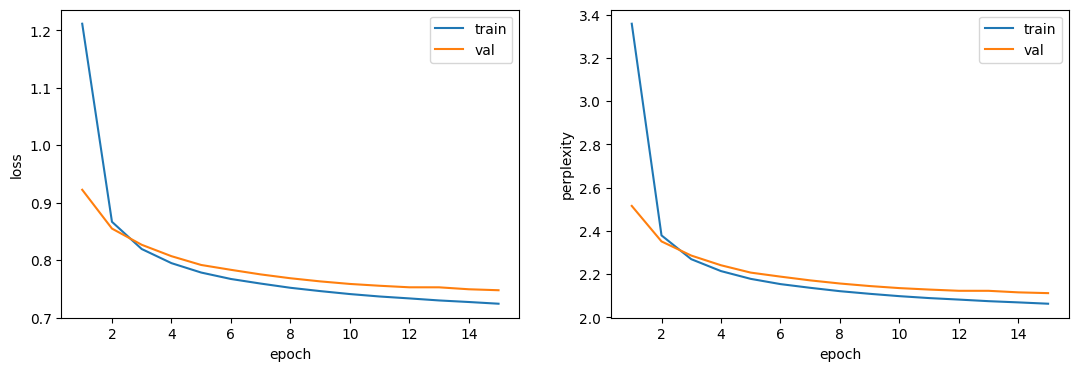

In [46]:
NUM_EPOCHS = 15
train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, f'Training {epoch}/{NUM_EPOCHS}', 'mouse_train_inp', 'mouse_train_trg', text_transform)
    end_time = timer()
    val_loss = valid_epoch(transformer, 'mouse_valid_inp', 'mouse_valid_trg', text_transform)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    train_losses += [train_loss]
    val_losses += [val_loss]
    plot_losses(train_losses, val_losses)

In [47]:
tmp_df_mouse['generated'] = tmp_df_mouse.apply(lambda x: answer(transformer, x['input'], text_transform, vocab_transform), axis=1)
tmp_df_mouse

input                                               path  Lev  \
342     mouse 1 1  О М Э Я Г Я Э М О Ы О М Я Э Ж Щ У З Я М И К А ...   -1   
343     mouse 1 2  О И К Д С Ш Е Л И М Я Г З У Щ Т Ж Э Я Э М О Ы ...   -1   
344     mouse 2 1  О Ф Х К И М Я Г Я Э Ж Т Щ У З Г З У Щ Т Щ У З ...   -1   
345     mouse 2 2  О Ф Ц З У Щ Т Щ У З Г З У Щ У З Ц Х К Л К А Д ...   -1   
346     mouse 2 3              О Ф Х К И Ф Ц Г З У Щ Т Ж Э М И Л Е Р   -1   
...           ...                                                ...  ...   
27475  mouse 34 4                                    О Ф Х А Д С Ш Р   -1   
27476  mouse 34 5                  О Ф Ц Г Я М О Ы О И К Л И М Э Ж Т   -1   
27477  mouse 34 6                                О Ф Х К И Ф М Э Ж Т   -1   
27478  mouse 35 1                        О Ф Ц Г Я Э М И К А Д С Ш Р   -1   
27479  mouse 35 2                                      О Ф Ц З У Щ Т   -1   

                generated  
342     О Ф Х А К Л Е Р Ш  
343     О Ф Х А К Л Е Р Ш  
344     О Ф Х А К Л Е Р Ш  
345     О Ф Х А К Л Е Р Ш  
346     О Ф Х А К И М Я Г  
...                   ...  
27475   О Ф Ц Г Ц Х А Д С  
27476   О Ф Ц Г Ц Х А Х Ц  
27477   О Ф Ц Г Ц Х А Х Ф  
27478   О Ф Ц Г Ц Х А К Л  
27479   О Ф Ц Г Ц Х А Д С  

[27138 rows x 4 columns]

In [48]:
tmp_df_mouse['Lev'] = -1
tmp_df_mouse['Lev'] = tmp_df_mouse.apply(lambda x: lev(''.join(x['generated'].split()), ''.join(x['path'].split())), axis=1)

In [49]:
tmp_df_mouse.sort_values(by='Lev')

input                                               path  Lev  \
3306   mouse 16 1                                    О Ф Ц Г Я Э Ж Т    0   
17982  mouse 17 1                                    О Ф Ц Г Я Э Ж Т    0   
23348  mouse 20 1                                    О Ф Ц Г Я Э Ж Т    0   
2077   mouse 22 1                                    О Ф Ц Г Я Э Ж Т    0   
15658  mouse 16 1                                    О Ф Ц Г Я Э Ж Т    0   
...           ...                                                ...  ...   
18390  mouse 12 3  О Ф Х А К И М Я Г Ц Х К Л И М Я Г Я Э Ж Т Ж Э ...  200   
8123    mouse 4 1  О Ф Ц Г Ц З У Щ Т Щ У З Ц Х А К Л Е Л К А Х Ф ...  204   
18386  mouse 11 1  О Ф Х А Д С Ш Р Е Л К Х Ц Г З У Щ Т Щ У З Г Ц ...  205   
19895   mouse 8 3  О Ф Ц Г Ц Х А К И Ф Ц Г Ц Х А К Л К А Х Ц Г Я ...  212   
27229   mouse 3 1  О Ф Х А Х Ц Г Я Э Я Г Ц Х А Д С Ш Р Ш С Д А Х ...  226   

                generated  
3306     О Ф Ц Г Я Э Ж Т   
17982    О Ф Ц Г Я Э Ж Т   
23348    О Ф Ц Г Я Э Ж Т   
2077     О Ф Ц Г Я Э Ж Т   
15658    О Ф Ц Г Я Э Ж Т   
...                   ...  
18390   О Ф Х А Х Ц Г Я Э  
8123    О Ф Х А К Л Е Р Ш  
18386   О Ф Х А К И М Я Г  
19895   О Ф Х А К И М Я Г  
27229   О Ф Х А К Л Е Р Ш  

[27138 rows x 4 columns]

In [66]:
for i in range(len(tmp_df_mouse)):
    if tmp_df_mouse['generated'].iloc[i][-1] == ' ':
        tmp_df_mouse['generated'].iloc[i] = tmp_df_mouse['generated'].iloc[i][:-1]

<ipython-input-66-f40454d7f126>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df_mouse['generated'].iloc[i] = tmp_df_mouse['generated'].iloc[i][:-1]


In [67]:
tmp_df_mouse['generated'] = tmp_df_mouse.apply(lambda x: x['generated'] + ' Р' if len(path_Nikolskaya(x['generated'][-1] + 'Р', maze_Nikolskaya)) < len(path_Nikolskaya(x['generated'][-1] + 'Т', maze_Nikolskaya)) else x['generated'] + ' Т', axis=1)

## Monkey

In [68]:
token_transform = {}
vocab_transform = {}
text_transform = {}

In [69]:
token_transform[SRC_] = get_tokenizer(None, language='en')
token_transform[TGT_] = get_tokenizer(None, language='en')

In [70]:
for el in [SRC_, TGT_]:
    train_iter = MyDataset(src_file='monkey_train_inp', tgt_file='monkey_train_trg')
    vocab_transform[el] = build_vocab_from_iterator(yield_tokens(train_iter, el),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

for el in [SRC_, TGT_]:
  vocab_transform[el].set_default_index(UNK_IDX)

In [72]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_])

transformer = Input2PathTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
for el in [SRC_, TGT_]:
    text_transform[el] = sequential_transforms(token_transform[el],
                                               vocab_transform[el],
                                               tensor_transform)

Training 1/15:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1, Train loss: 3.526, Val loss: 2.656, Epoch time = 0.238s


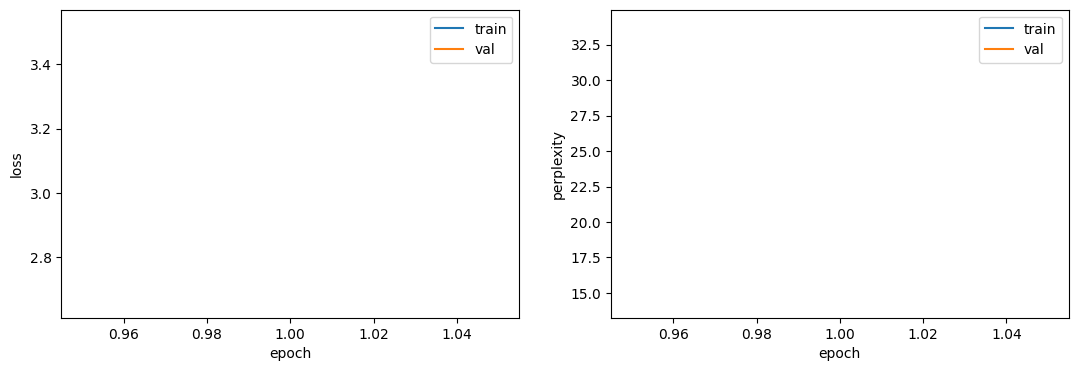

Training 2/15:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 2, Train loss: 2.743, Val loss: 2.469, Epoch time = 0.201s


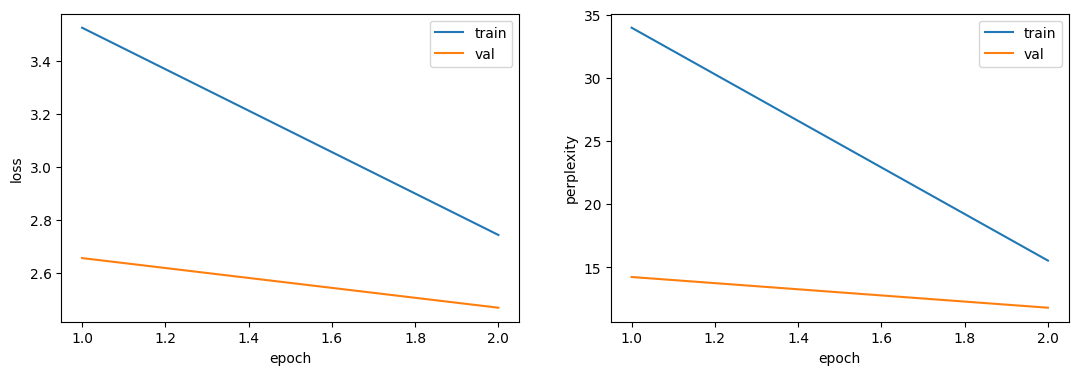

Training 3/15:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 3, Train loss: 2.348, Val loss: 2.151, Epoch time = 0.198s


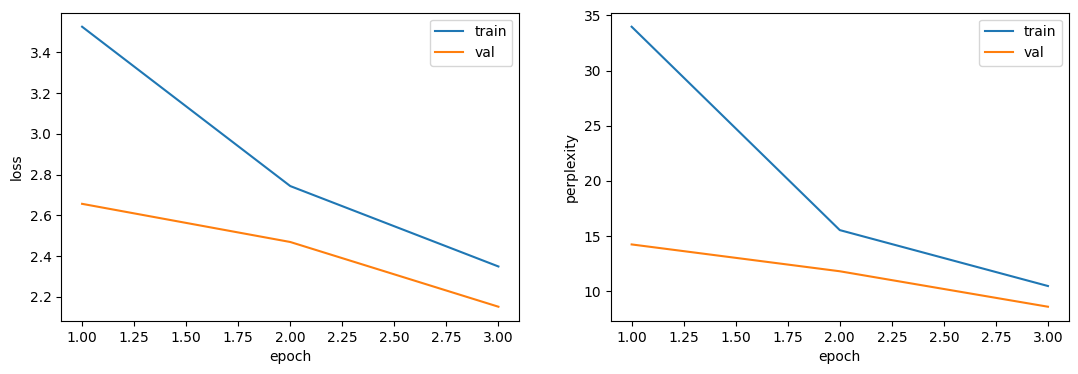

Training 4/15:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4, Train loss: 2.161, Val loss: 1.865, Epoch time = 0.228s


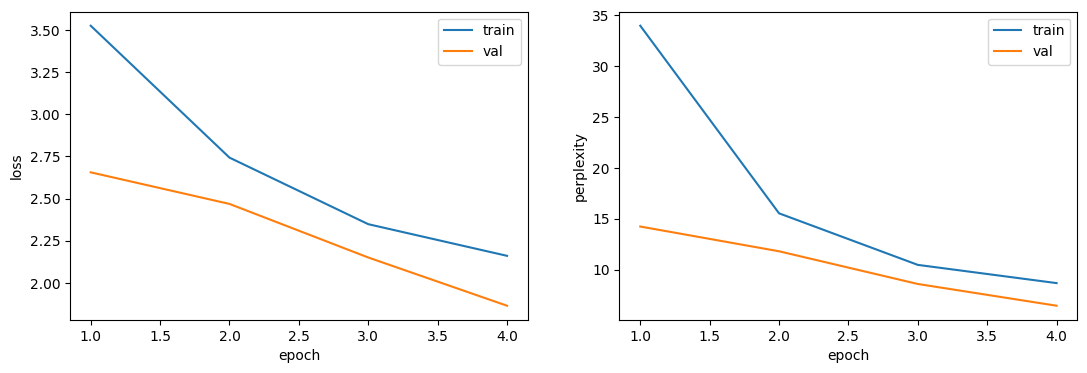

Training 5/15:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5, Train loss: 1.842, Val loss: 1.601, Epoch time = 0.201s


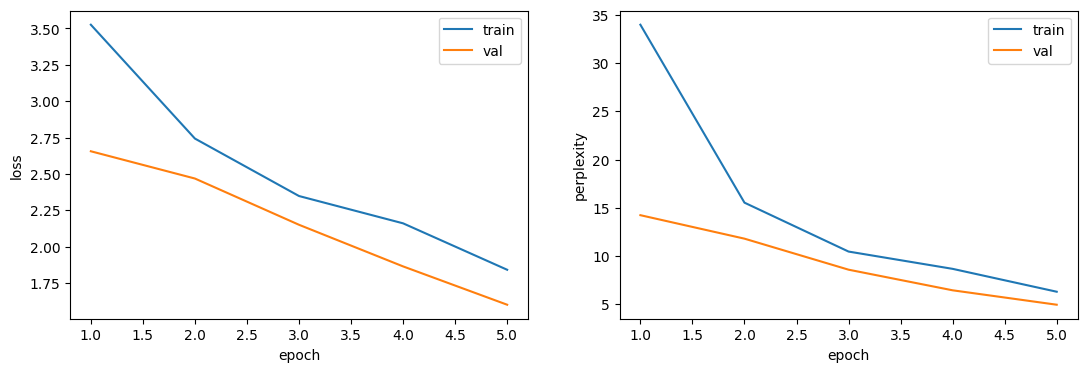

Training 6/15:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 6, Train loss: 1.624, Val loss: 1.419, Epoch time = 0.201s


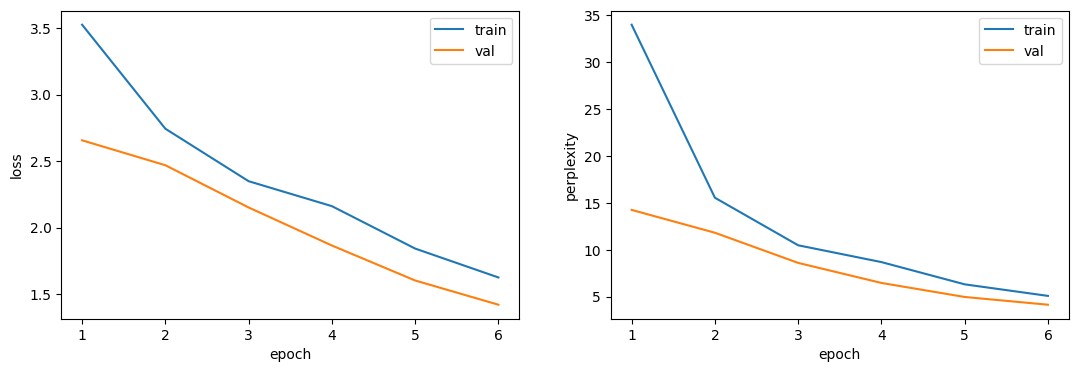

Training 7/15:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 7, Train loss: 1.415, Val loss: 1.271, Epoch time = 0.199s


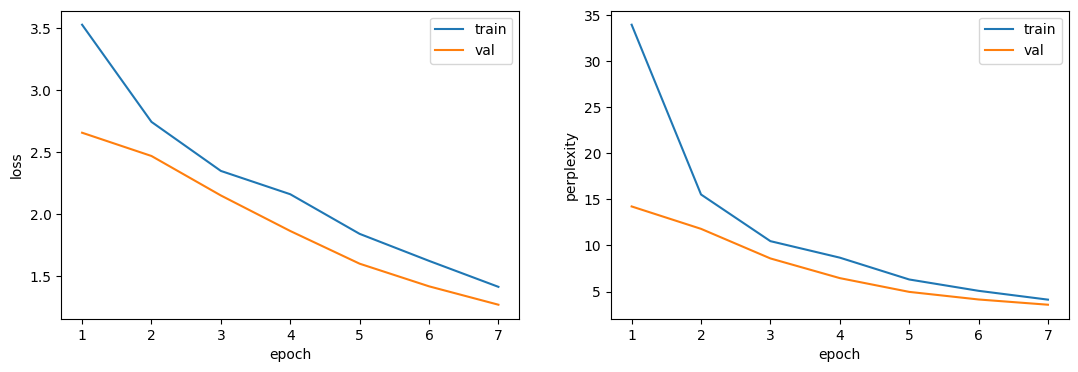

Training 8/15:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 8, Train loss: 1.288, Val loss: 1.145, Epoch time = 0.188s


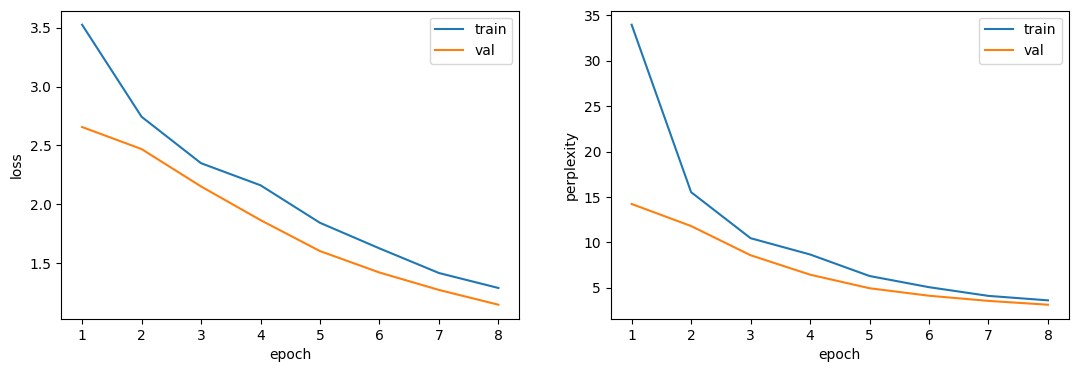

Training 9/15:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 9, Train loss: 1.198, Val loss: 1.134, Epoch time = 0.195s


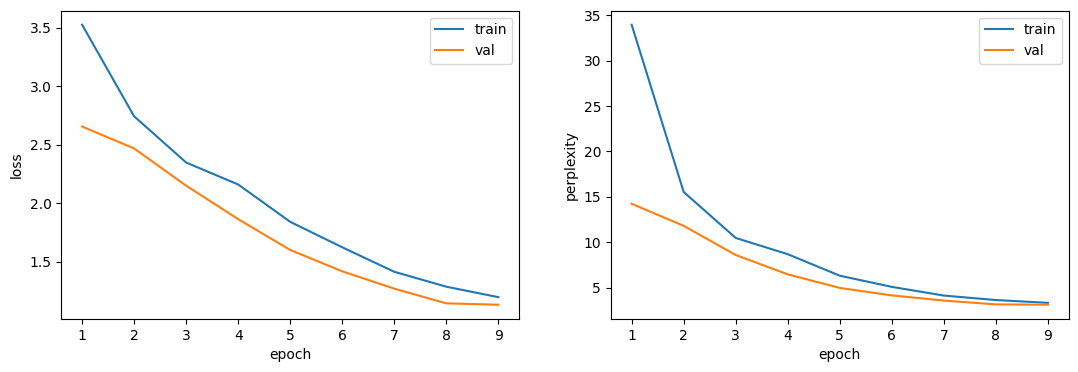

Training 10/15:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10, Train loss: 1.117, Val loss: 1.057, Epoch time = 0.191s


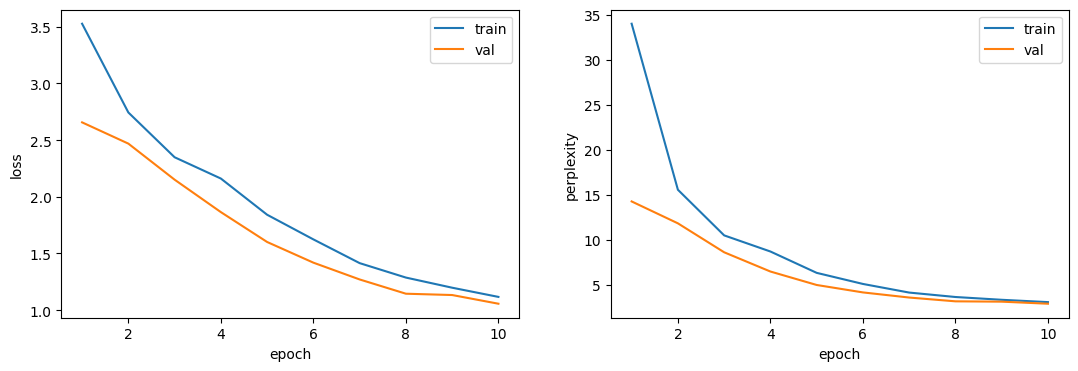

Training 11/15:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11, Train loss: 1.058, Val loss: 0.991, Epoch time = 0.201s


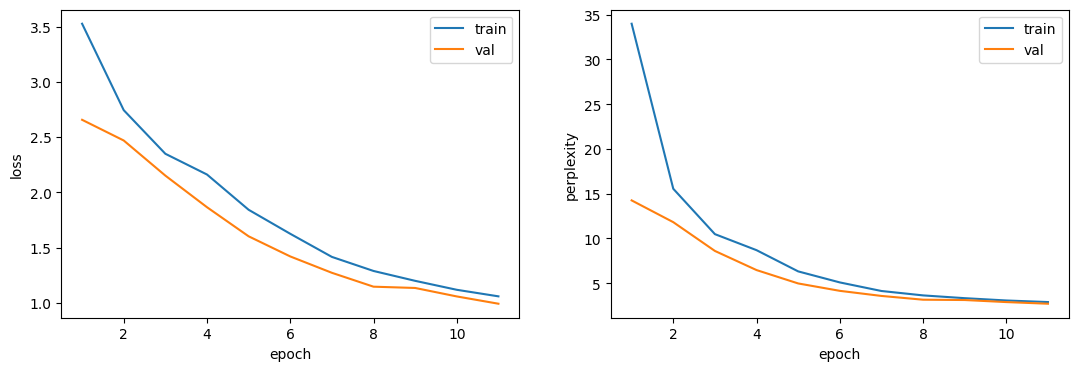

Training 12/15:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12, Train loss: 0.999, Val loss: 0.964, Epoch time = 0.197s


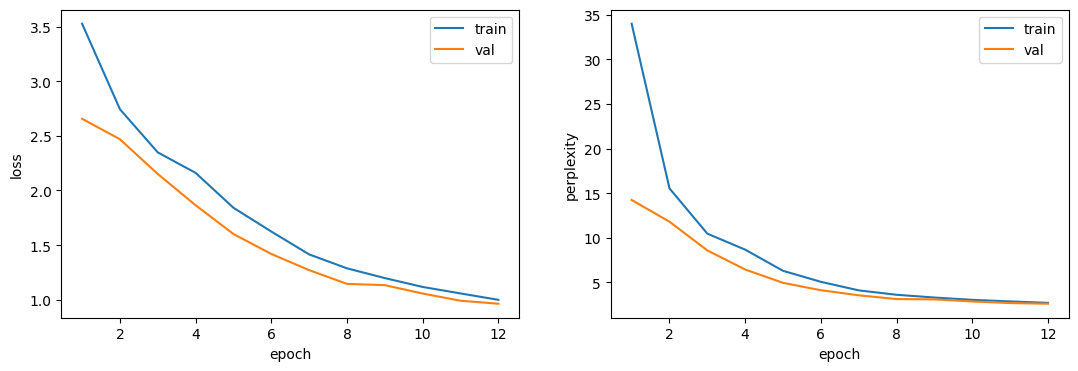

Training 13/15:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13, Train loss: 0.950, Val loss: 0.928, Epoch time = 0.218s


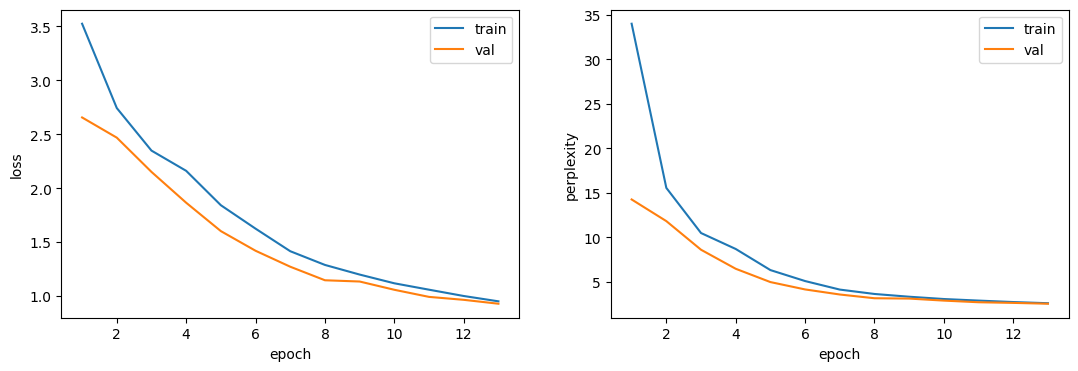

Training 14/15:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14, Train loss: 0.906, Val loss: 0.920, Epoch time = 0.226s


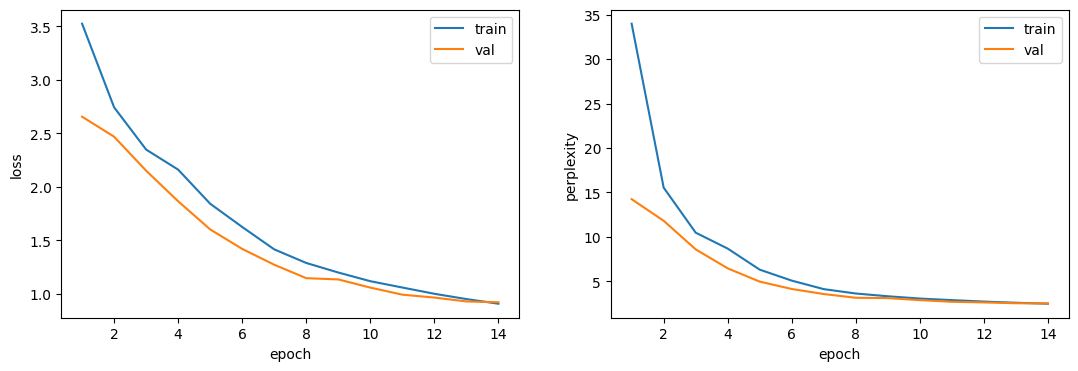

Training 15/15:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15, Train loss: 0.851, Val loss: 0.863, Epoch time = 0.204s


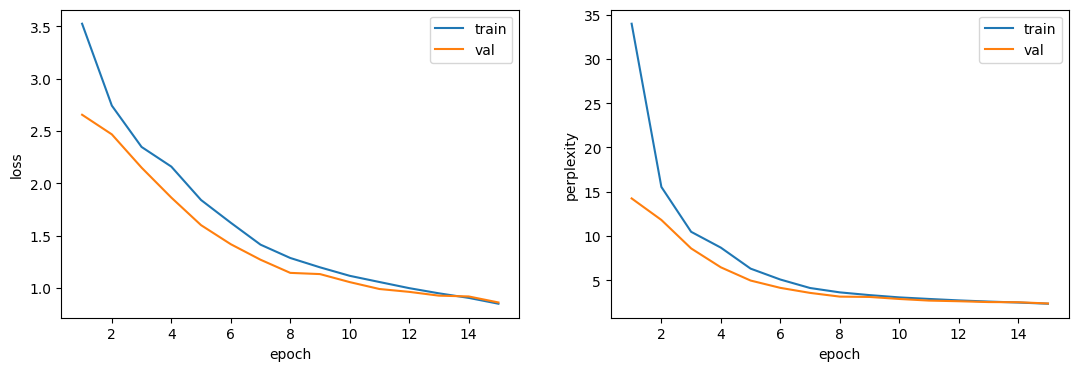

In [73]:
NUM_EPOCHS = 15
train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, f'Training {epoch}/{NUM_EPOCHS}', 'monkey_train_inp', 'monkey_train_trg', text_transform)
    end_time = timer()
    val_loss = valid_epoch(transformer, 'monkey_valid_inp', 'monkey_valid_trg', text_transform)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    train_losses += [train_loss]
    val_losses += [val_loss]
    plot_losses(train_losses, val_losses)

In [74]:
tmp_df_monkey['generated'] = tmp_df_monkey.apply(lambda x: answer(transformer, x['input'], text_transform, vocab_transform), axis=1)
tmp_df_monkey

input                                               path  \
29002    monkey 3 1   О М Э Ж У З Г З У Ж Э Э Ж У З З З Г Я Э Ж У З...   
29003    monkey 3 2                      О М Я Г Я Я З У Ж Э М И Л Е Р   
29004    monkey 4 1  Ы О М Я Г З У Ж Э Э У З Я М И Л Е Е С Д С Е Б ...   
29005    monkey 4 2   О М Я З У Ж В В Э М И Л Е С Д Д С Е Б Л И М В...   
29006    monkey 4 3                      О М Э В Ж Ж Э М И Л Е Е Б Е Р   
...             ...                                                ...   
29213  monkey 15 11                      О М Я Г Я М И К А К И М Э Ж Т   
29214  monkey 15 12                                О И К А К И М Э Ж Т   
29215  monkey 15 13                                О И К А К И М Э Ж Т   
29216  monkey 15 14                                О И К А К И М Э Ж Т   
29217  monkey 15 15                            О И К К И М Я Г Я Э Ж Т   

                generated  
29002   О И К А К И М Я Г  
29003   О И К А К И М Я Г  
29004   О И К А К И М Я Г  
29005   О И К А К И М Я Г  
29006   О И К А К И М Я Г  
...                   ...  
29213   О И К А К И М Я Г  
29214   О И К А К И М Э Ж  
29215   О И К А К И М Я Г  
29216   О И К А К И М Я Г  
29217   О И К А К И М Э Ж  

[216 rows x 3 columns]

In [75]:
tmp_df_monkey['Lev'] = -1
tmp_df_monkey['Lev'] = tmp_df_monkey.apply(lambda x: lev(''.join(x['generated'].split()), ''.join(x['path'].split())), axis=1)

In [76]:
tmp_df_monkey.sort_values(by='Lev')

input                                               path  \
29214  monkey 15 12                                О И К А К И М Э Ж Т   
29138  monkey 11 24                                О И К А К И М Э Ж Т   
29123   monkey 11 9                            О И К А К И М Я Г З У Т   
29069   monkey 8 22                            О И К А К И М Я Г З У Т   
29125  monkey 11 11                            О И К А К И М Я Г З У Т   
...             ...                                                ...   
29004    monkey 4 1  Ы О М Я Г З У Ж Э Э У З Я М И Л Е Е С Д С Е Б ...   
29208   monkey 15 6  О И К А К И М Э Ж Ж Э М И Л Е Е Б Л К А К И М ...   
29117   monkey 11 3   О И К А К И М Я Г З У Ж Э М И К А К И М Я Г Я...   
29015    monkey 5 3   Н О М Э Ж У З Я Я З З Я М И К Д Д К Л Е Е Б Л...   
29048    monkey 8 1  О И К А К И М Я Г Я М И К А К И М Я Г Я Э В Ж ...   

                generated  Lev  
29214   О И К А К И М Э Ж    1  
29138   О И К А К И М Я Г    3  
29123   О И К А К И М Я Г    3  
29069   О И К А К И М Я Г    3  
29125   О И К А К И М Я Г    3  
...                   ...  ...  
29004   О И К А К И М Я Г   30  
29208   О И К А К И М Я Г   30  
29117   О И К А К И М Я Г   33  
29015   О И К А К И М Я Г   42  
29048   О И К А К И М Я Г   45  

[216 rows x 4 columns]

In [77]:
tmp_df_monkey['generated'] = tmp_df_monkey.apply(lambda x: x['generated'] + ' Р' if len(path_Nikolskaya(x['generated'][-1] + 'Р', maze_Nikolskaya)) < len(path_Nikolskaya(x['generated'][-1] + 'Т', maze_Nikolskaya)) else x['generated'] + ' Т', axis=1)

In [78]:
tmp_df_monkey

input                                               path  \
29002    monkey 3 1   О М Э Ж У З Г З У Ж Э Э Ж У З З З Г Я Э Ж У З...   
29003    monkey 3 2                      О М Я Г Я Я З У Ж Э М И Л Е Р   
29004    monkey 4 1  Ы О М Я Г З У Ж Э Э У З Я М И Л Е Е С Д С Е Б ...   
29005    monkey 4 2   О М Я З У Ж В В Э М И Л Е С Д Д С Е Б Л И М В...   
29006    monkey 4 3                      О М Э В Ж Ж Э М И Л Е Е Б Е Р   
...             ...                                                ...   
29213  monkey 15 11                      О М Я Г Я М И К А К И М Э Ж Т   
29214  monkey 15 12                                О И К А К И М Э Ж Т   
29215  monkey 15 13                                О И К А К И М Э Ж Т   
29216  monkey 15 14                                О И К А К И М Э Ж Т   
29217  monkey 15 15                            О И К К И М Я Г Я Э Ж Т   

                  generated  Lev  
29002   О И К А К И М Я Г Т   24  
29003   О И К А К И М Я Г Т   13  
29004   О И К А К И М Я Г Т   30  
29005   О И К А К И М Я Г Т   26  
29006   О И К А К И М Я Г Т   13  
...                     ...  ...  
29213   О И К А К И М Я Г Т    8  
29214   О И К А К И М Э Ж Т    1  
29215   О И К А К И М Я Г Т    3  
29216   О И К А К И М Я Г Т    3  
29217   О И К А К И М Э Ж Т    5  

[216 rows x 4 columns]

## Person

In [79]:
token_transform = {}
vocab_transform = {}
text_transform = {}

In [80]:
token_transform[SRC_] = get_tokenizer(None, language='en')
token_transform[TGT_] = get_tokenizer(None, language='en')

In [81]:
for el in [SRC_, TGT_]:
    train_iter = MyDataset(src_file='person_train_inp', tgt_file='person_train_trg')
    vocab_transform[el] = build_vocab_from_iterator(yield_tokens(train_iter, el),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

for el in [SRC_, TGT_]:
  vocab_transform[el].set_default_index(UNK_IDX)

In [82]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_])

transformer = Input2PathTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
for el in [SRC_, TGT_]:
    text_transform[el] = sequential_transforms(token_transform[el],
                                               vocab_transform[el],
                                               tensor_transform)

Training 1/15:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1, Train loss: 3.189, Val loss: 2.387, Epoch time = 1.643s


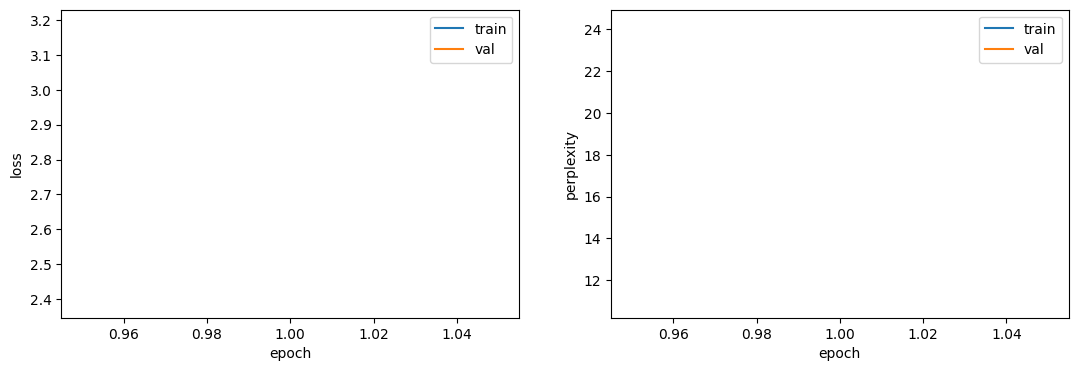

Training 2/15:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2, Train loss: 1.731, Val loss: 1.261, Epoch time = 1.620s


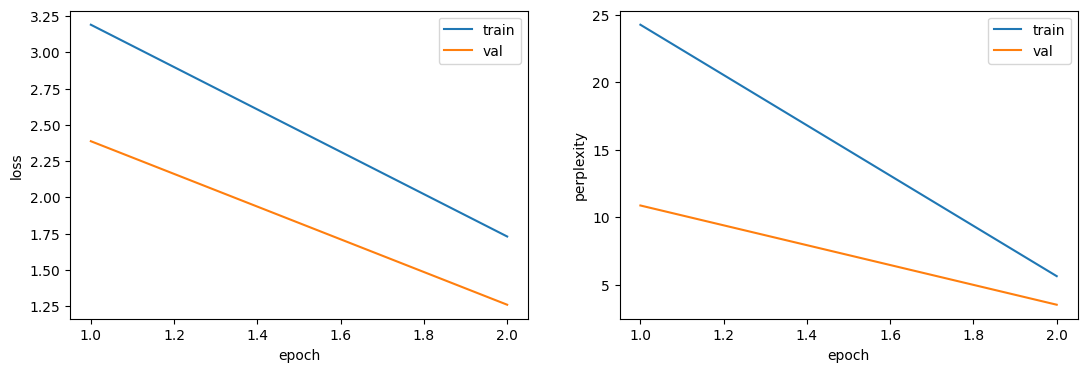

Training 3/15:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3, Train loss: 1.053, Val loss: 0.949, Epoch time = 1.662s


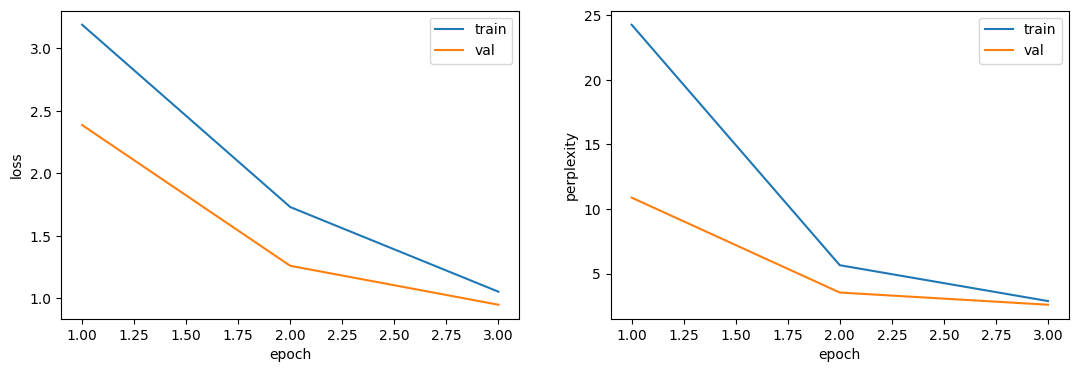

Training 4/15:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.835, Val loss: 0.807, Epoch time = 1.616s


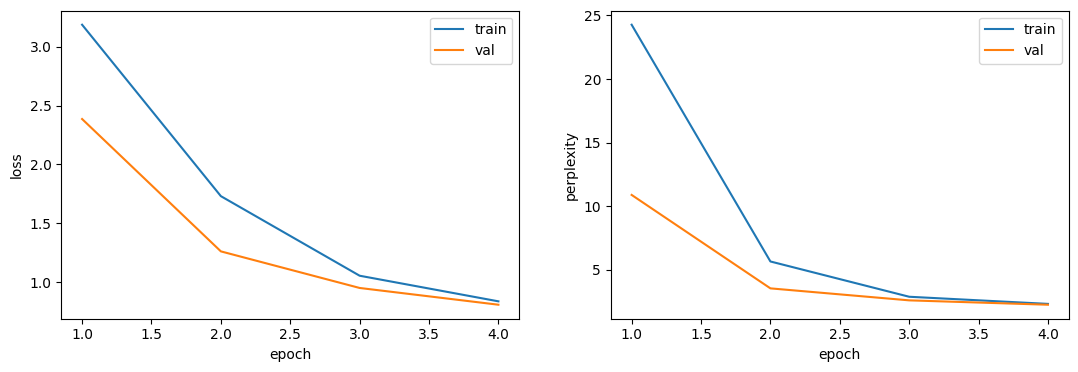

Training 5/15:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5, Train loss: 0.732, Val loss: 0.740, Epoch time = 1.627s


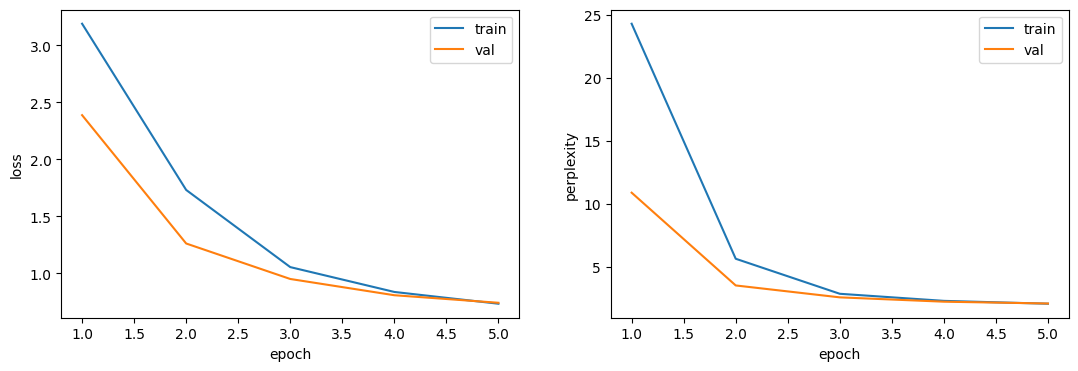

Training 6/15:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6, Train loss: 0.674, Val loss: 0.697, Epoch time = 1.654s


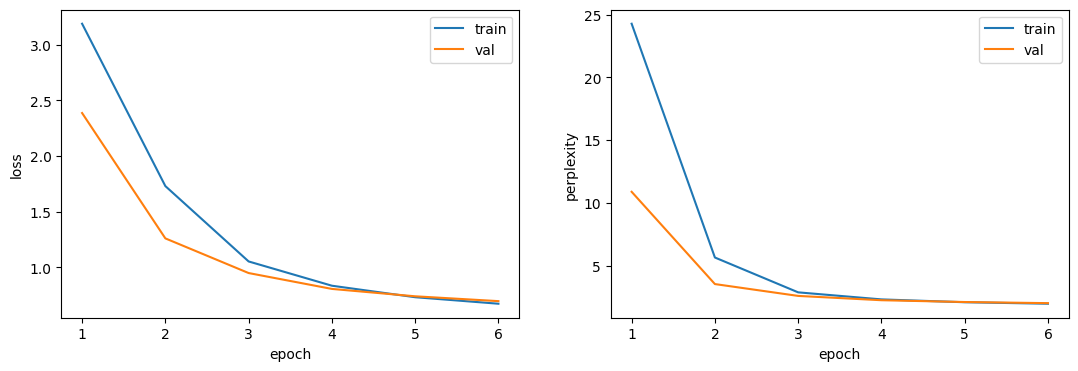

Training 7/15:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7, Train loss: 0.645, Val loss: 0.674, Epoch time = 1.635s


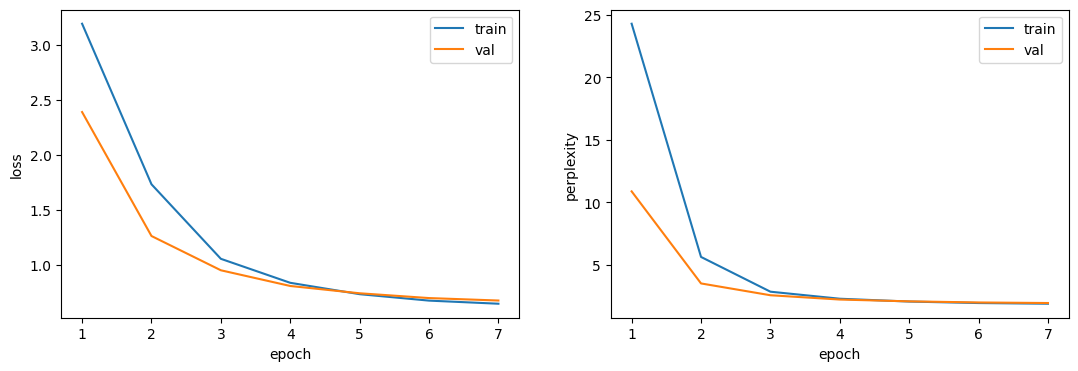

Training 8/15:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8, Train loss: 0.613, Val loss: 0.666, Epoch time = 1.733s


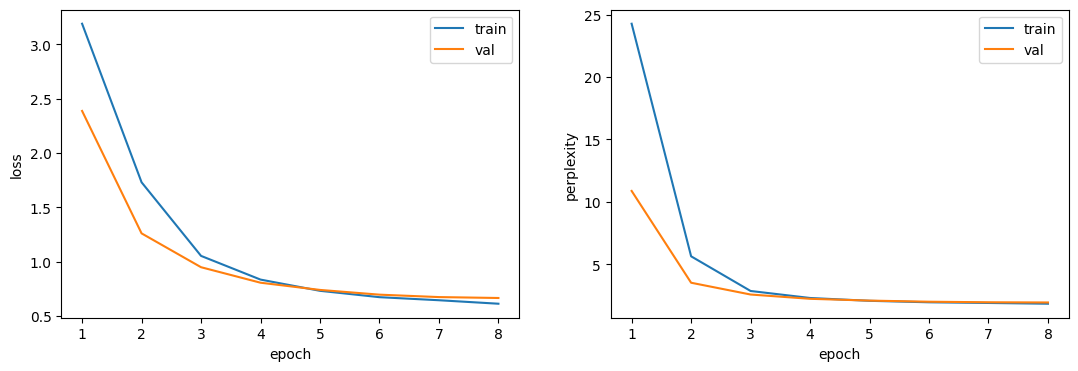

Training 9/15:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9, Train loss: 0.603, Val loss: 0.654, Epoch time = 1.677s


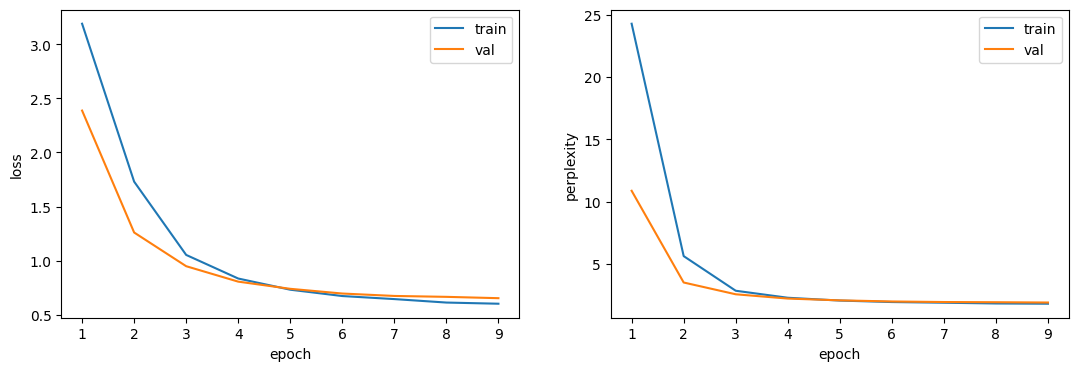

Training 10/15:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10, Train loss: 0.584, Val loss: 0.641, Epoch time = 1.671s


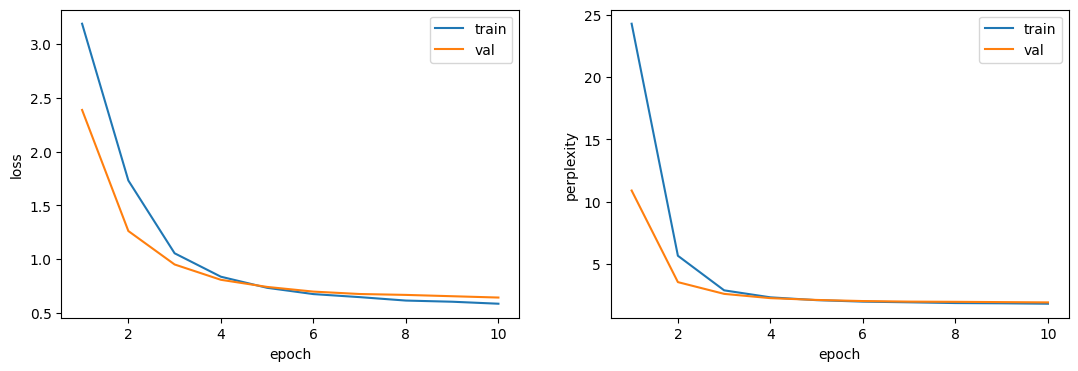

Training 11/15:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11, Train loss: 0.570, Val loss: 0.636, Epoch time = 1.674s


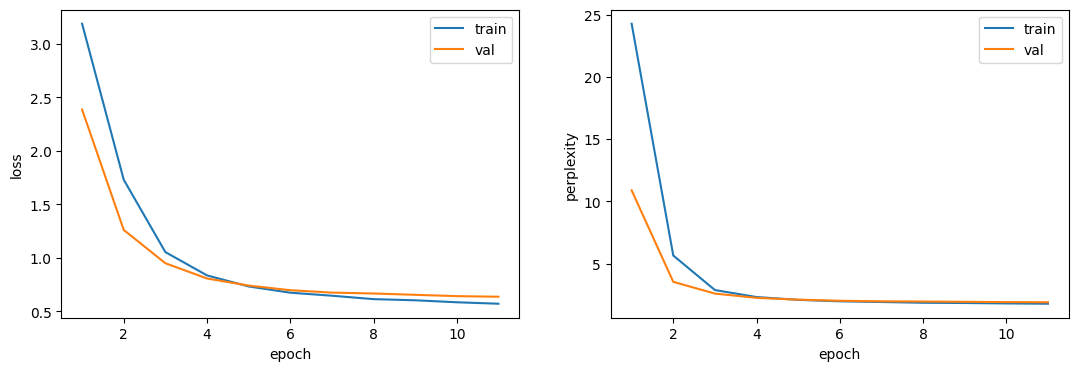

Training 12/15:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12, Train loss: 0.561, Val loss: 0.627, Epoch time = 1.687s


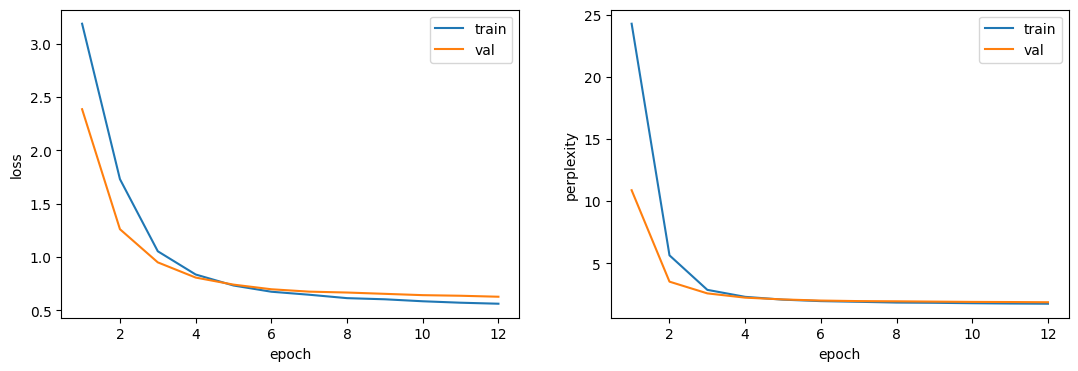

Training 13/15:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13, Train loss: 0.548, Val loss: 0.622, Epoch time = 1.678s


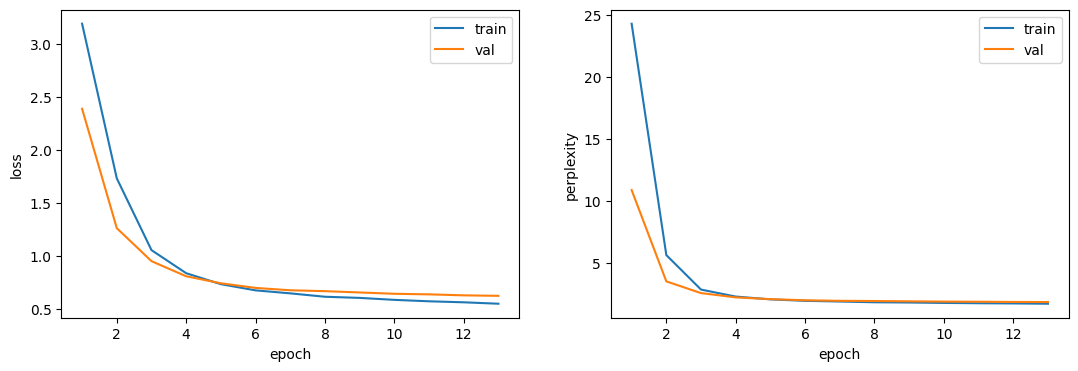

Training 14/15:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14, Train loss: 0.542, Val loss: 0.617, Epoch time = 1.743s


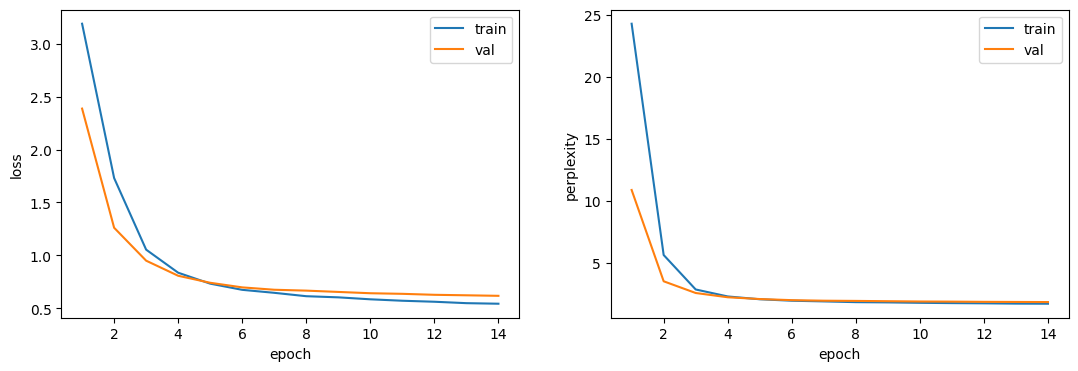

Training 15/15:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15, Train loss: 0.533, Val loss: 0.611, Epoch time = 1.673s


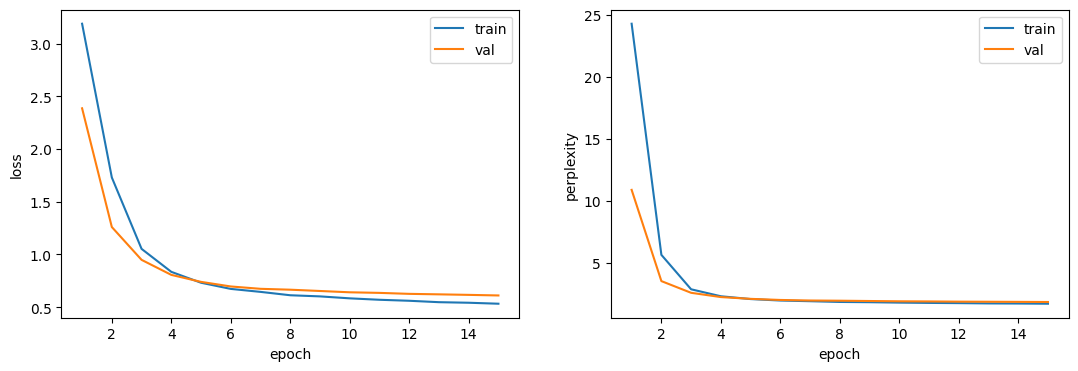

In [83]:
NUM_EPOCHS = 15
train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, f'Training {epoch}/{NUM_EPOCHS}', 'person_train_inp', 'person_train_trg', text_transform)
    end_time = timer()
    val_loss = valid_epoch(transformer, 'person_valid_inp', 'person_valid_trg', text_transform)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    train_losses += [train_loss]
    val_losses += [val_loss]
    plot_losses(train_losses, val_losses)

In [84]:
tmp_df_person['generated'] = tmp_df_person.apply(lambda x: answer(transformer, x['input'], text_transform, vocab_transform), axis=1)
tmp_df_person

input                                               path  \
27480   person 1 1  Ы О М Я Г Ц Х А Д С Ш Е Б Л И К А К И О Ы О Ф ...   
27481   person 2 1  Ы О И Л Б Е Р Ш С Д А А Х Ц Г З У Щ Ж В Э М О ...   
27482   person 3 1  Ы О М Я Г З Г Ц Х А Д С Ш Е Б Л И О М Э В Ж Т ...   
27483   person 4 1          Ы О Ф Х А Д А К И О Ф Ц Г З Г Ц Г З У Щ Т   
27484   person 5 1                            Ы О Ф Х А Х Ц Г З У Щ Т   
...            ...                                                ...   
28997  person 15 1                        Ы О М Я Г Я Г Ц Х А Д С Ш Р   
28998  person 16 1                        Ы О М Я Г Я Г Ц Х А Д С Ш Р   
28999  person 17 1                      Ы О Ф Ц Г З З Г Ц Х А Д С Ш Р   
29000  person 18 1                          Ы О М Я Г Г Ц Х А Д С Ш Р   
29001  person 19 1                        Ы О М Я Г Я Г Ц Х А Д С Ш Р   

                generated  
27480   Ы О Ф Х А Д С Ш Р  
27481   Ы О Ф Х А Х Ц Г З  
27482   Ы О Ф Х А Х Ц Г З  
27483   Ы О Ф Х А Х Ц Г З  
27484   Ы О Ф Х А Х Ц Г З  
...                   ...  
28997   Ы О Ф Х А Х Ц Г З  
28998   Ы О Ф Х А Х Ц Г З  
28999   Ы О Ф Х А Х Ц Г З  
29000   Ы О Ф Х А Х Ц Г З  
29001   Ы О Ф Х А Х Ц Г З  

[1522 rows x 3 columns]

In [85]:
tmp_df_person['Lev'] = -1
tmp_df_person['Lev'] = tmp_df_person.apply(lambda x: lev(''.join(x['generated'].split()), ''.join(x['path'].split())), axis=1)

In [86]:
tmp_df_person.sort_values(by='Lev')

input                                               path  \
28618   person 1 1                                  Ы О Ф Х А Д С Ш Р   
27629   person 1 1                                  Ы О И К А Д С Ш Р   
27755  person 16 1                            Ы О Ф Х А Х Ц Г З У Щ Т   
27758  person 19 1                            Ы О Ф Х А Х Ц Г З У Щ Т   
27759  person 20 1                            Ы О Ф Х А Х Ц Г З У Щ Т   
...            ...                                                ...   
27768   person 3 1  Ы О Ф Ц Г З У Щ Т Ж В Э М Я Г Ц Х А Д С Ш Е Б ...   
28421   person 1 1  Ы О И К А Д С Ш Р Е Б Л И О Ы О М Я Г З У Щ Т ...   
28572   person 2 1  Ы О Ф Х А Х Ц Г З У Щ Ж В Э М Я Г Ц Ф Ф Х А К ...   
28871   person 2 1  Ы О Ф Х А Д С Ш Р Е Б Л И К А Д С Ш Р Е Б Л И ...   
28925   person 3 1  Ы О И К А Д А Х Ф О М Я Г З У Щ Ж В Э М О И И ...   

                generated  Lev  
28618   Ы О Ф Х А Д С Ш Р    0  
27629   Ы О Ф Х А Д С Ш Р    2  
27755   Ы О Ф Х А Х Ц Г З    3  
27758   Ы О Ф Х А Х Ц Г З    3  
27759   Ы О Ф Х А Х Ц Г З    3  
...                   ...  ...  
27768   Ы О Ф Х А Х Ц Г З   60  
28421   Ы О Ф Х А Д С Ш Р   90  
28572   Ы О Ф Х А Х Ц Г З   95  
28871   Ы О Ф Х А Х Ц Г З  109  
28925   Ы О Ф Х А Х Ц Г З  170  

[1522 rows x 4 columns]

In [88]:
tmp_df_person['generated'] = tmp_df_person.apply(lambda x: x['generated'] + ' Р' if len(path_Nikolskaya(x['generated'][-1] + 'Р', maze_Nikolskaya)) < len(path_Nikolskaya(x['generated'][-1] + 'Т', maze_Nikolskaya)) else x['generated'] + ' Т', axis=1)

In [96]:
tmp_df_mouse.to_csv('mouse_res.csv', sep=';', encoding="utf-8-sig")
tmp_df_fish.to_csv('fish_res.csv', sep=';', encoding="utf-8-sig")
tmp_df_monkey.to_csv('monkey_res.csv', sep=';', encoding="utf-8-sig")
tmp_df_person.to_csv('person_res.csv', sep=';', encoding="utf-8-sig")

In [97]:
from google.colab import files
files.download('fish_res.csv') 
files.download('mouse_res.csv') 
files.download('monkey_res.csv') 
files.download('person_res.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>